Short script to look at price data pickle.

In [ ]:
import pandas as pd

file_path = 'data/raw/all_tickers_historical_data.pkl'

try:
    data = pd.read_pickle(file_path)
    
    # --- PART 1: Inspecting the Nested 'QCOM' Dictionary ---
    print(f"--- 1. Deep Dive into 'QCOM' ---")
    
    if 'QCOM' in data:
        qcom_val = data['QCOM']
        
        # We know qcom_val is a dict, so let's look at its keys
        if isinstance(qcom_val, dict):
            print(f"Keys found inside 'QCOM': {list(qcom_val.keys())}\n")
            
            for sub_key, sub_val in qcom_val.items():
                print(f"Key: ['{sub_key}']")
                print(f"   Type: {type(sub_val)}")
                
                # If it's a DataFrame, show columns and first row
                if isinstance(sub_val, pd.DataFrame):
                    print(f"   Shape: {sub_val.shape}")
                    print(f"   Columns: {list(sub_val.columns)}")
                    print(sub_val.head(2).to_string()) # Print first 2 rows clearly
                
                # If it's a simple value or list, print it directly
                else:
                    print(f"   Value: {sub_val}")
                print("-" * 30)
    else:
        print("Key 'QCOM' not found (weird, since we saw it earlier).")

    # --- PART 2: Searching for S&P 500 Keys ---
    print(f"\n--- 2. Searching for S&P 500 Keys ---")
    
    # Common variations for the S&P 500
    search_terms = ['sp500', 's&p', 'spx', 'gspc', 'spy', 'index']
    found_keys = []

    # Case-insensitive search through all top-level keys
    for key in data.keys():
        key_str = str(key).lower()
        if any(term in key_str for term in search_terms):
            found_keys.append(key)

    if found_keys:
        print(f"Found {len(found_keys)} potential matches:")
        print(found_keys)
    else:
        print("No keys found matching typical S&P 500 terms (sp500, s&p, gspc, spy).")

except Exception as e:
    print(f"Error: {e}")

Data exploration for the new multiclass labels.

Configuration: Symmetric Thresholds Loaded
Loading data/raw/ml_dataset_with_multiclass_labels.csv...

--- Categorical Label Distributions (Symmetric) ---


C:\Users\bnroo\AppData\Local\Temp\ipykernel_4004\3122472217.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_counts.index, y=val_counts.values, ax=ax, palette="viridis")
C:\Users\bnroo\AppData\Local\Temp\ipykernel_4004\3122472217.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_counts.index, y=val_counts.values, ax=ax, palette="viridis")
C:\Users\bnroo\AppData\Local\Temp\ipykernel_4004\3122472217.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_counts.index, y=val_counts.values, ax=ax, palette="viridis")
C:\User

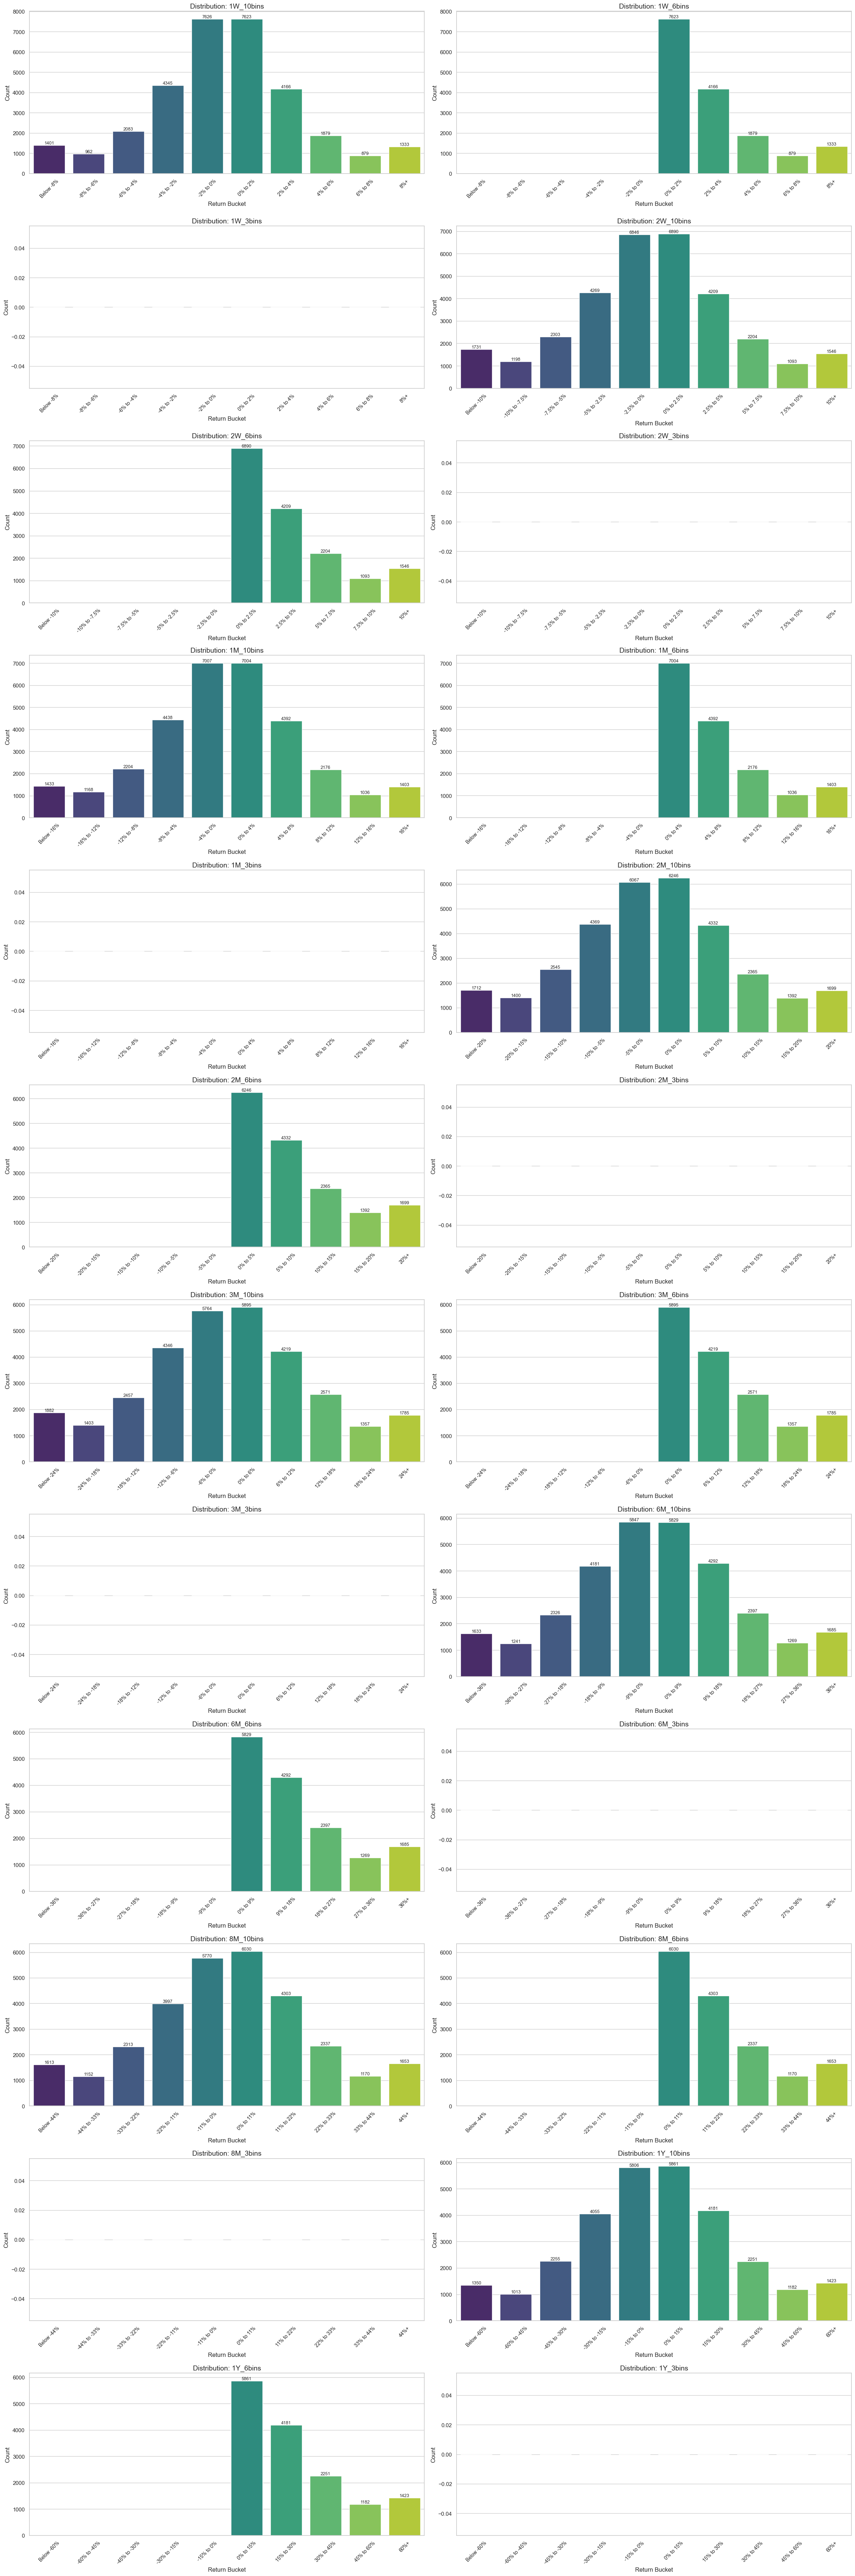

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
from IPython.display import display

# ================= CONFIGURATION =================
FILE_PATH = 'data/raw/ml_dataset_with_multiclass_labels.csv'
CLIP_PCT = 0.0005 

# Base POSITIVE thresholds (Must match the generation script)
_BASE_THRESHOLDS = {
    '1W': [0, 2, 4, 6, 8],
    '2W': [0, 2.5, 5, 7.5, 10],
    '1M': [0, 4, 8, 12, 16],
    '2M': [0, 5, 10, 15, 20],
    '3M': [0, 6, 12, 18, 24],
    '6M': [0, 9, 18, 27, 36],
    '8M': [0, 11, 22, 33, 44],
    '1Y': [0, 15, 30, 45, 60]
}

# Generate Full Symmetric Thresholds dynamically
LABEL_THRESHOLDS = {}
for p, vals in _BASE_THRESHOLDS.items():
    negatives = sorted([-x for x in vals if x != 0])
    full_list = negatives + sorted(vals)
    LABEL_THRESHOLDS[p] = full_list

print("Configuration: Symmetric Thresholds Loaded")
# =================================================

def generate_label_order(period_name):
    """
    Reconstructs the expected string labels for a given period 
    to ensure the X-axis is sorted Low -> High (Negative -> Positive).
    """
    if period_name not in LABEL_THRESHOLDS:
        return None
        
    thresholds = [x/100.0 for x in LABEL_THRESHOLDS[period_name]]
    labels = []
    
    # 1. Lowest Bin (e.g. Below -8%)
    labels.append(f"Below {thresholds[0]*100:g}%")
    
    # 2. Intermediate Bins
    for i in range(len(thresholds) - 1):
        low = thresholds[i]
        high = thresholds[i+1]
        
        # Format strings (handle negatives)
        low_str = f"{low*100:g}" 
        high_str = f"{high*100:g}"
        labels.append(f"{low_str}% to {high_str}%")
        
    # 3. Highest Bin (e.g. 8%+)
    labels.append(f"{thresholds[-1]*100:g}%+")
    return labels

def plot_categorical_grid(df, cols):
    """
    Plots a grid of Bar Charts for the new symmetric categorical labels.
    """
    n_cols = 2  # Fewer columns because charts will be wider with more bars
    n_rows = (len(cols) + n_cols - 1) // n_cols 
    
    # Taller and Wider figure to accommodate 9-11 bars per chart
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6 * n_rows))
    axes = axes.flatten()
    
    print(f"\n--- Categorical Label Distributions (Symmetric) ---")
    
    for i, col in enumerate(cols):
        ax = axes[i]
        
        period = col.split('_')[0]
        order = generate_label_order(period)
        
        # Count values
        val_counts = df[col].value_counts()
        
        # Force sort order
        if order:
            val_counts = val_counts.reindex(order).fillna(0)
        
        # Plot
        # Viridis is good here because it shows the progression from Low -> High
        sns.barplot(x=val_counts.index, y=val_counts.values, ax=ax, palette="viridis")
        
        ax.set_title(f'Distribution: {col}', fontsize=14)
        ax.set_ylabel('Count')
        ax.set_xlabel('Return Bucket')
        
        # Rotate labels significantly because there are many of them now
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        
        # Add text annotations
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}', 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', fontsize=9)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def main():
    if not os.path.exists(FILE_PATH):
        print(f"Error: File not found at {FILE_PATH}")
        return

    print(f"Loading {FILE_PATH}...")
    df = pd.read_csv(FILE_PATH)
    
    bin_cols = [col for col in df.columns if col.endswith('bins')]
    
    if not bin_cols:
        print("Error: No '_bins' columns found.")
        return

    # Run the plotting function
    plot_categorical_grid(df, bin_cols)

if __name__ == "__main__":
    main()

Convert txt results files to csv

Scanning: C:\Users\bnroo\OneDrive\Desktop\Algotrading\CongressTradingProj\logs\12M
Found 22 log files.

[SKIP] No valid data found in: multilabel_binary_20260109_140644.txt
[SKIP] No valid data found in: multilabel_binary_20260109_141614.txt
[SKIP] No valid data found in: multilabel_binary_20260109_143800.txt
[SKIP] No valid data found in: multilabel_binary_20260109_144425.txt
FILE: multilabel_binary_20260109_144842.txt
Saved CSV to: multilabel_binary_20260109_144842.csv (25 rows)


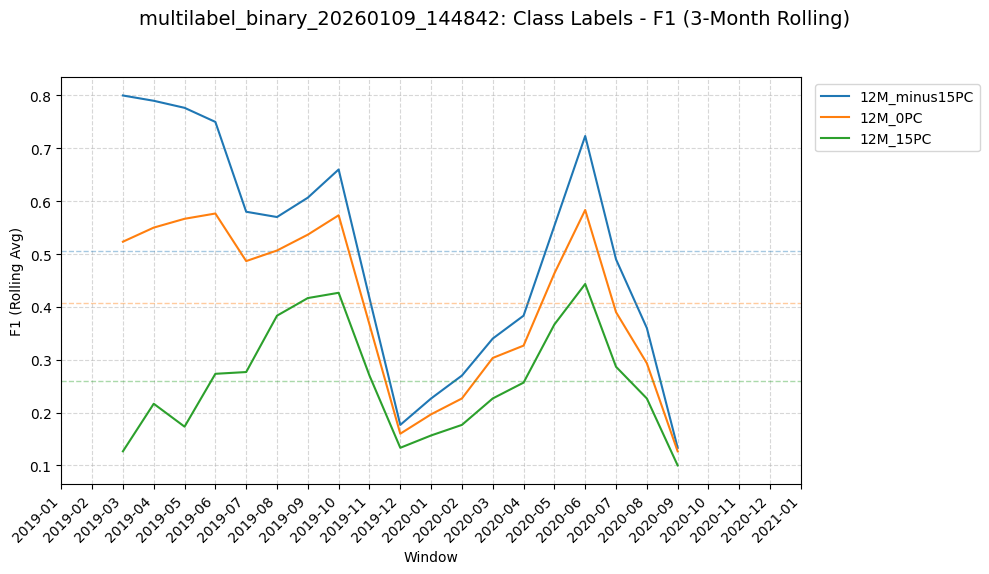

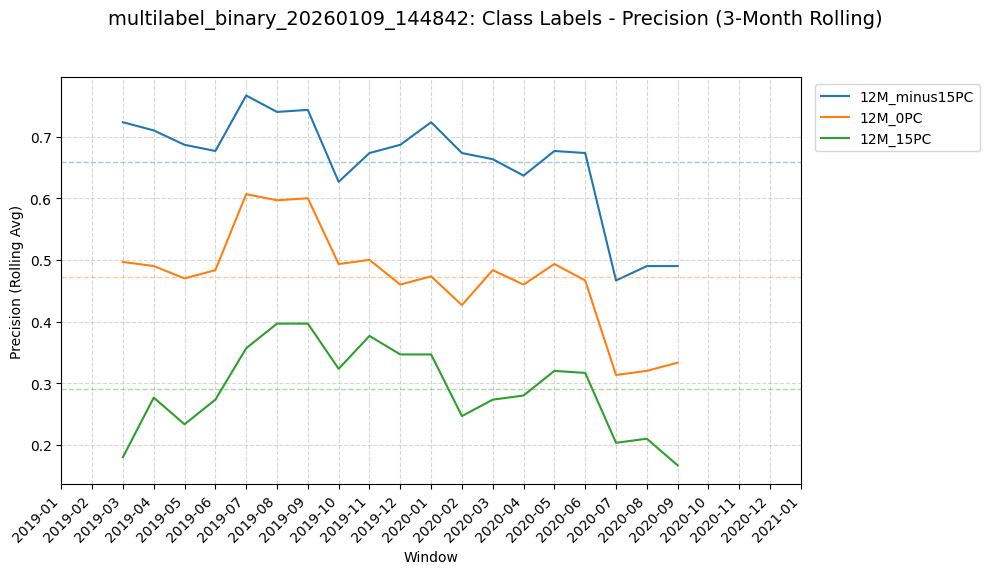

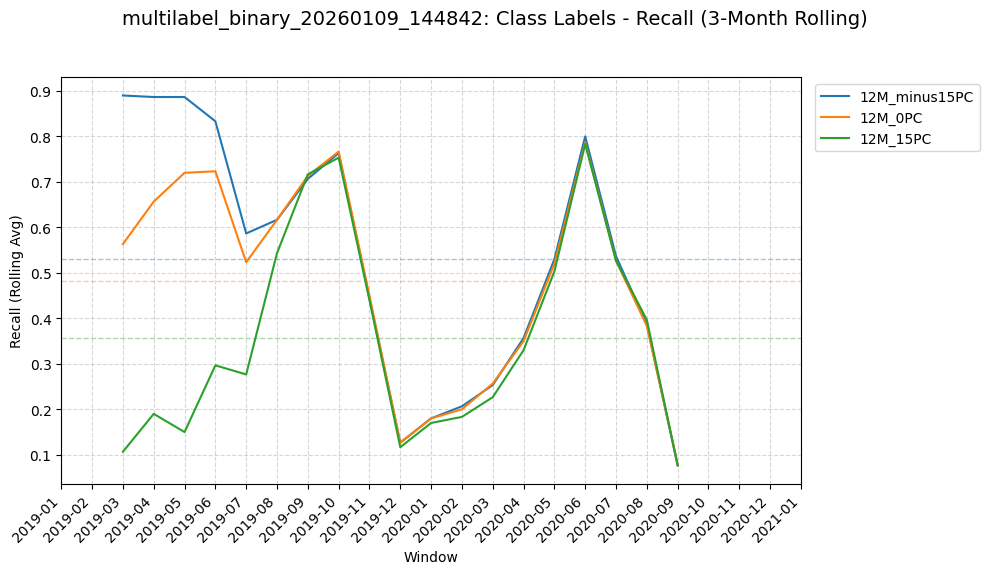

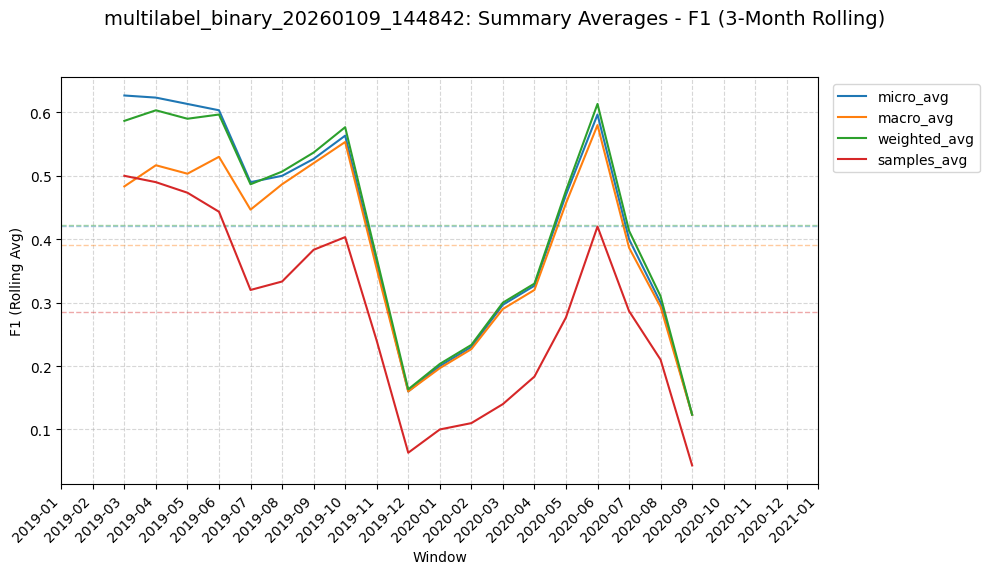

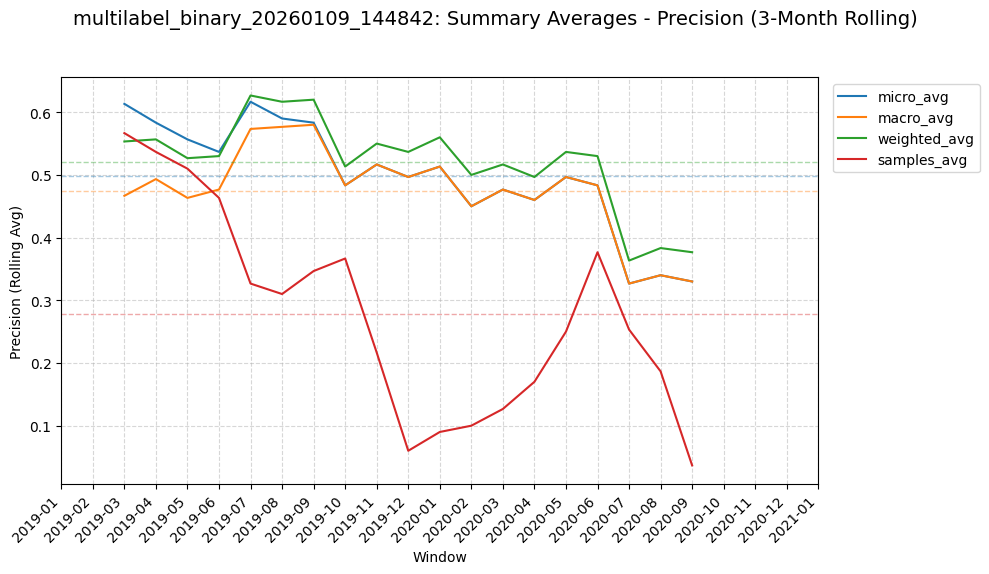

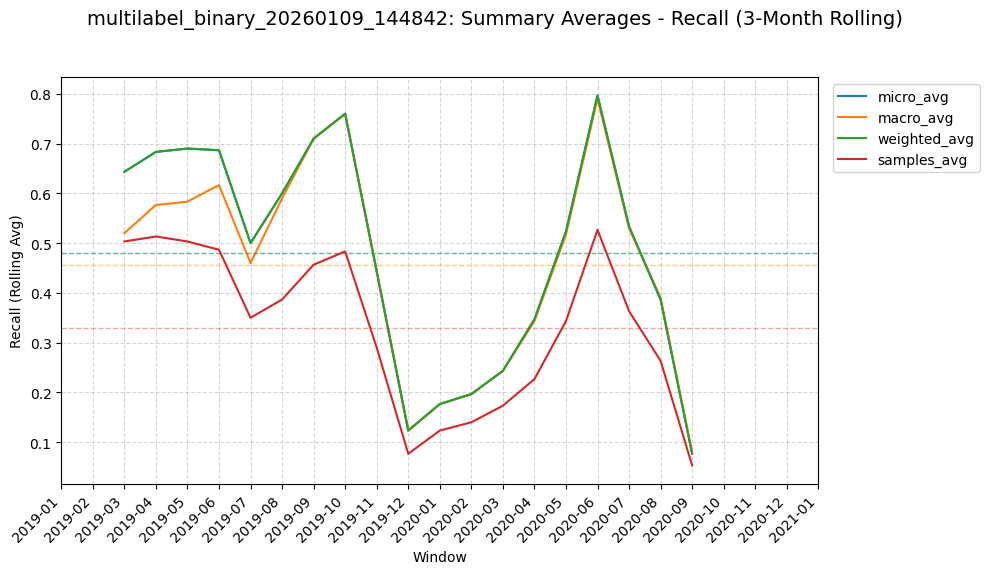

[SKIP] No valid data found in: multilabel_binary_20260109_154102.txt
[SKIP] No valid data found in: multilabel_binary_20260109_154830.txt
[SKIP] No valid data found in: multilabel_binary_20260109_155216.txt
FILE: multilabel_binary_20260109_155238.txt
Saved CSV to: multilabel_binary_20260109_155238.csv (5 rows)


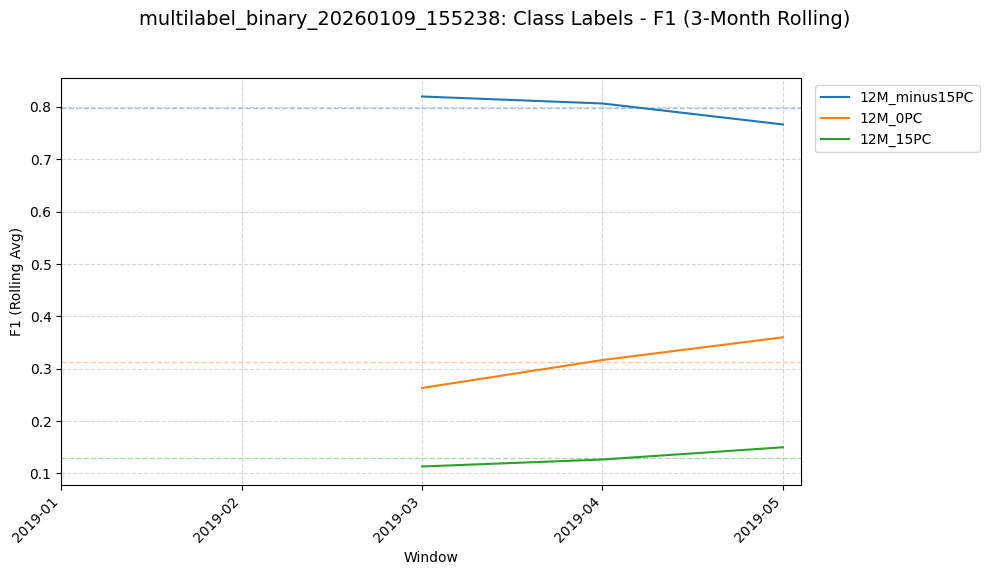

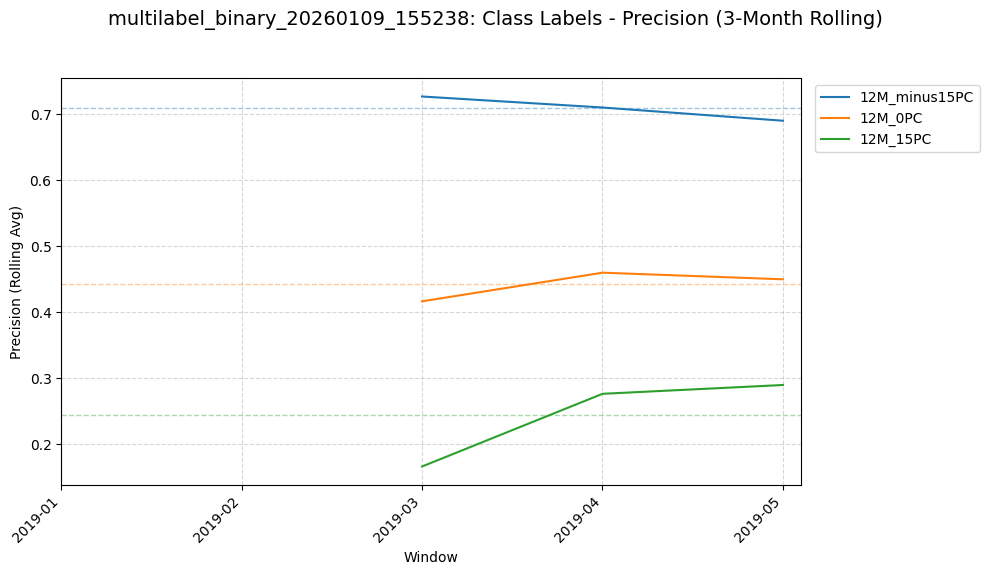

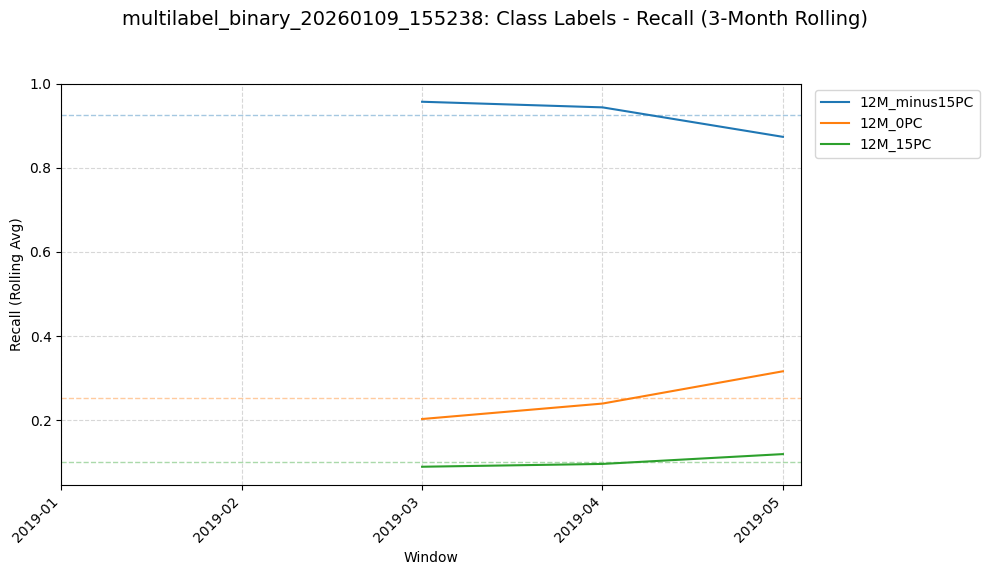

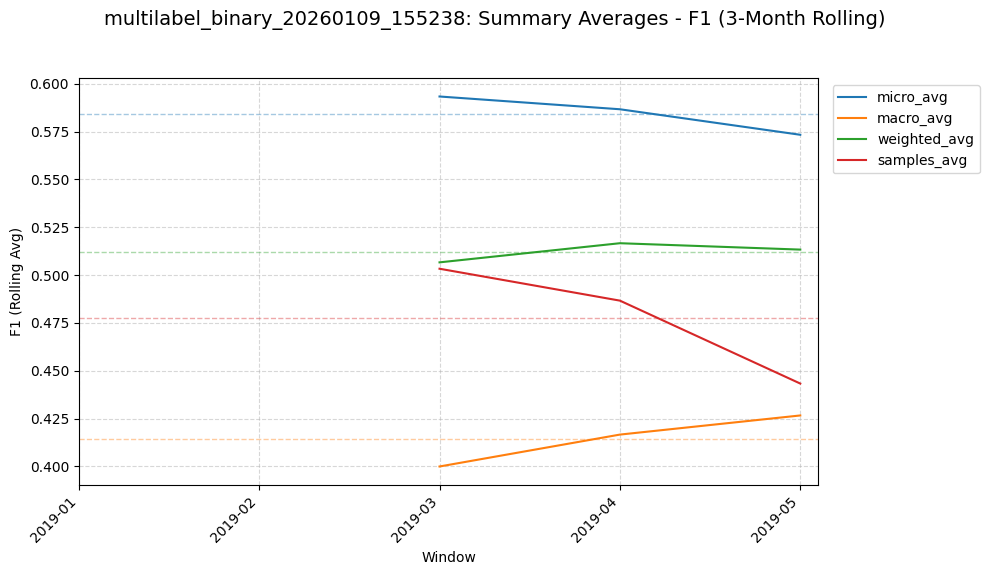

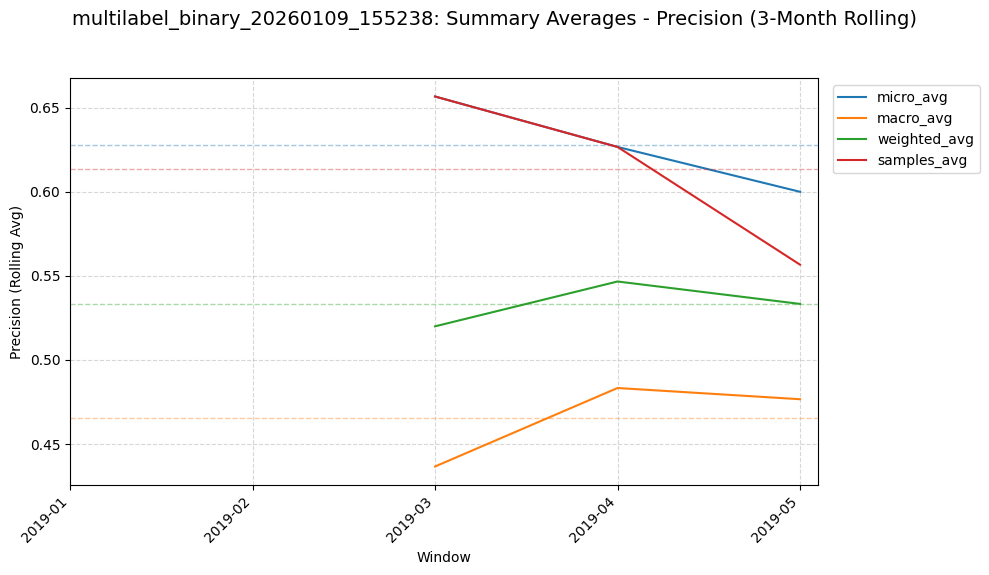

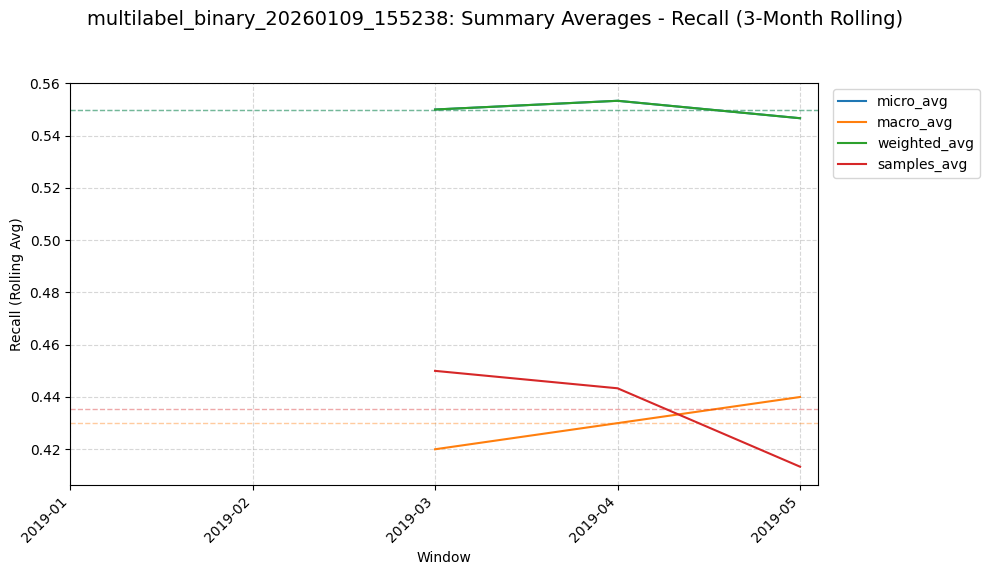

[SKIP] No valid data found in: multilabel_binary_20260109_160505.txt
[SKIP] No valid data found in: multilabel_binary_20260109_160711.txt
[SKIP] No valid data found in: multilabel_binary_20260109_160753.txt
[SKIP] No valid data found in: multilabel_binary_20260109_161224.txt
[SKIP] No valid data found in: multilabel_binary_20260109_161346.txt
FILE: multilabel_binary_20260109_162224.txt
Saved CSV to: multilabel_binary_20260109_162224.csv (20 rows)


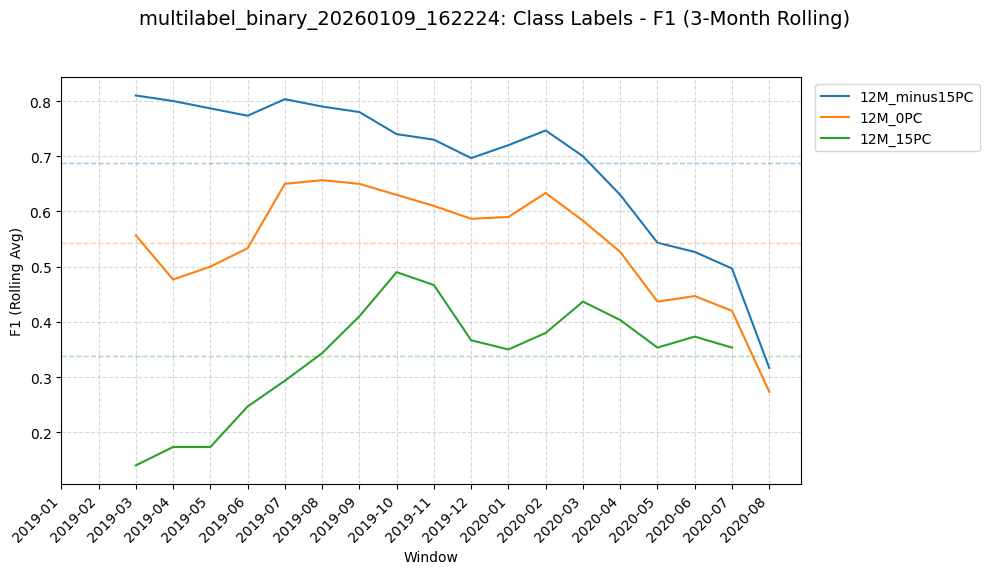

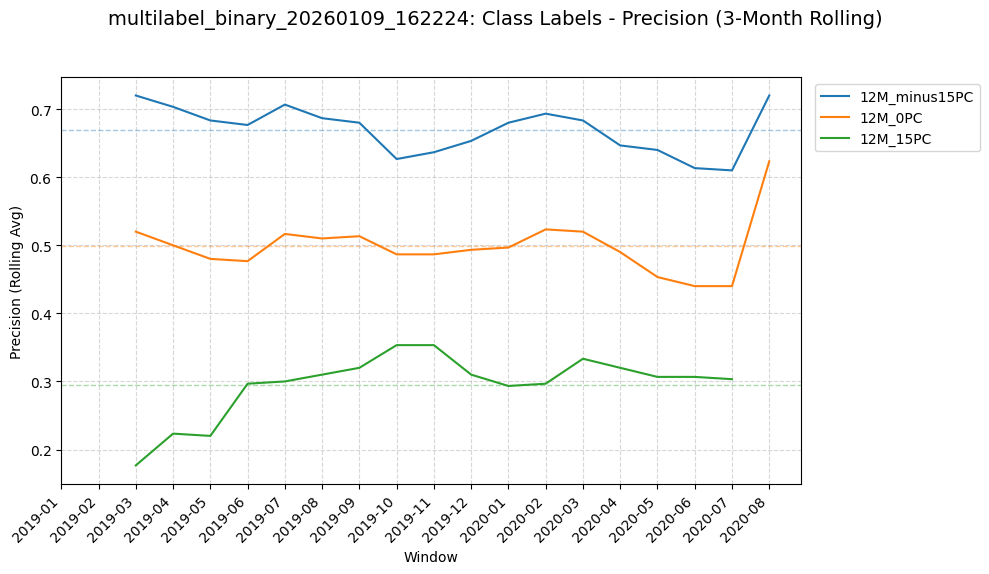

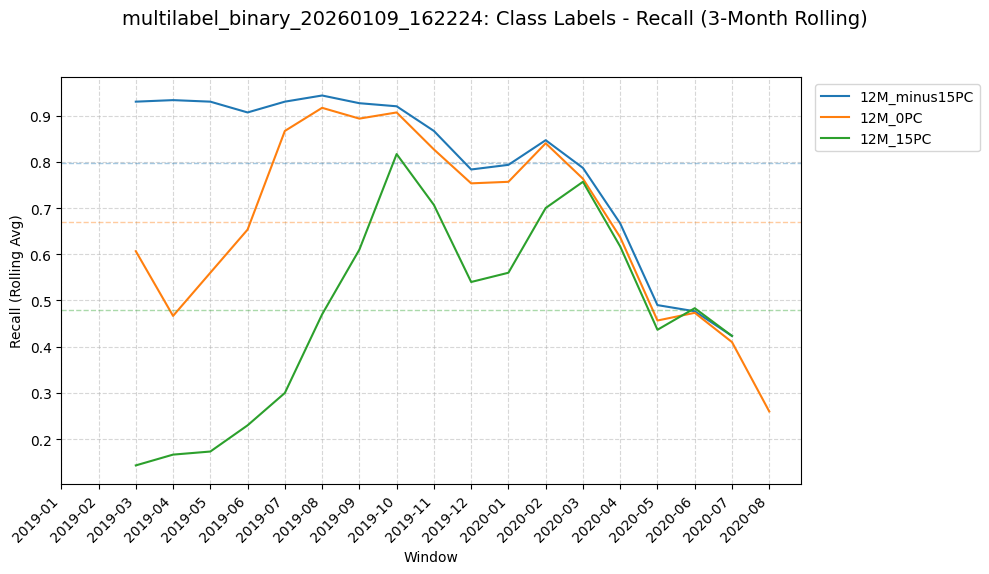

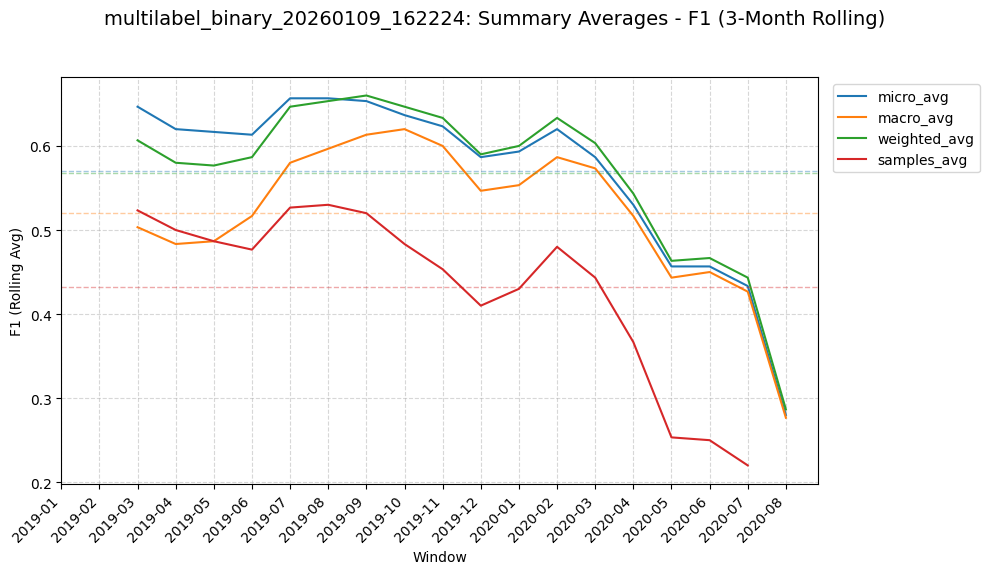

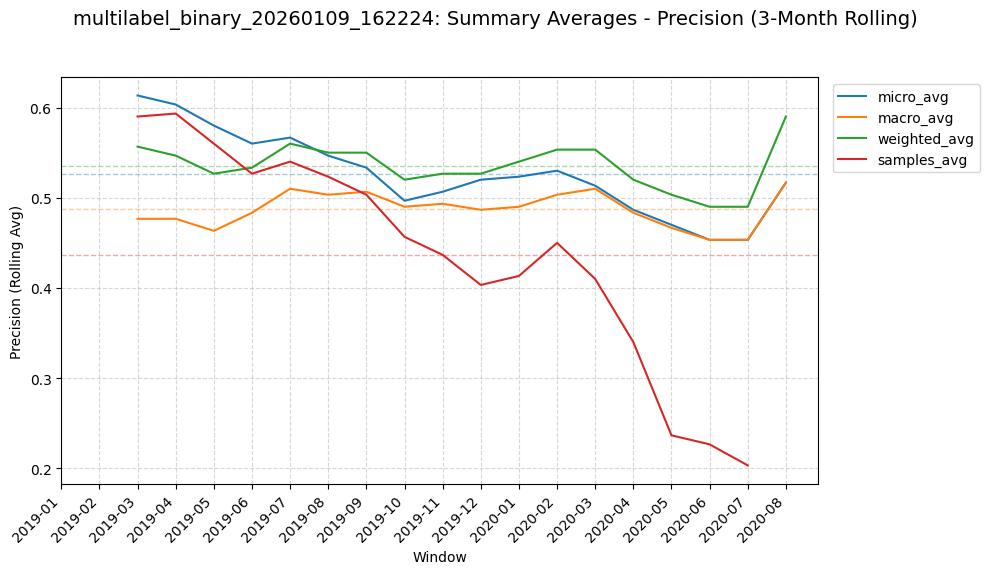

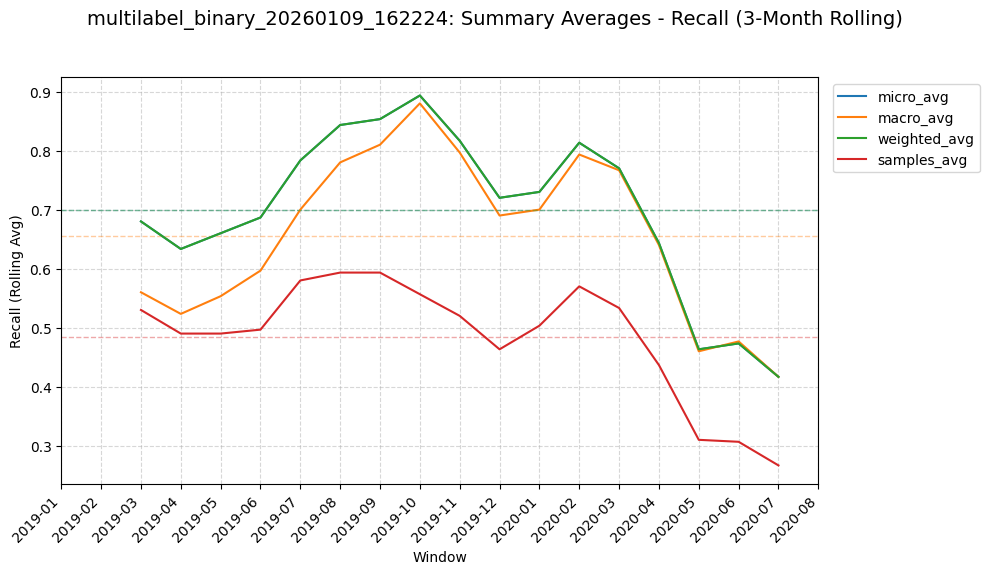

FILE: multilabel_binary_20260109_171941.txt
Saved CSV to: multilabel_binary_20260109_171941.csv (24 rows)


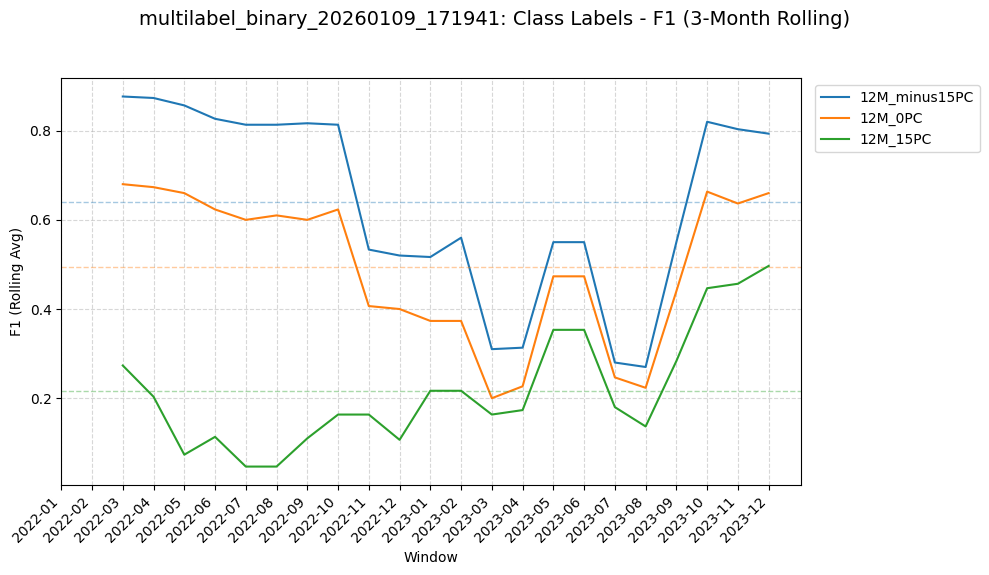

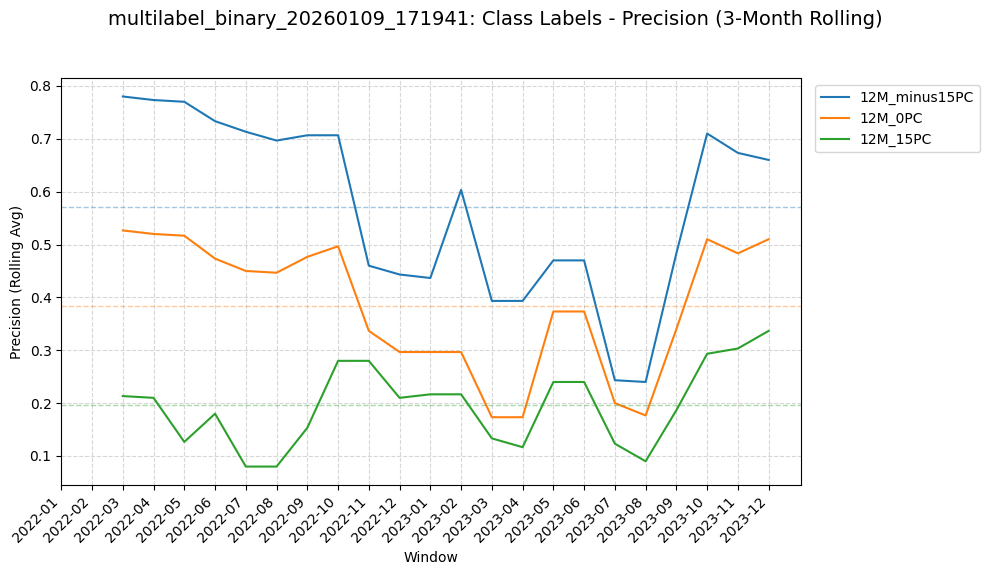

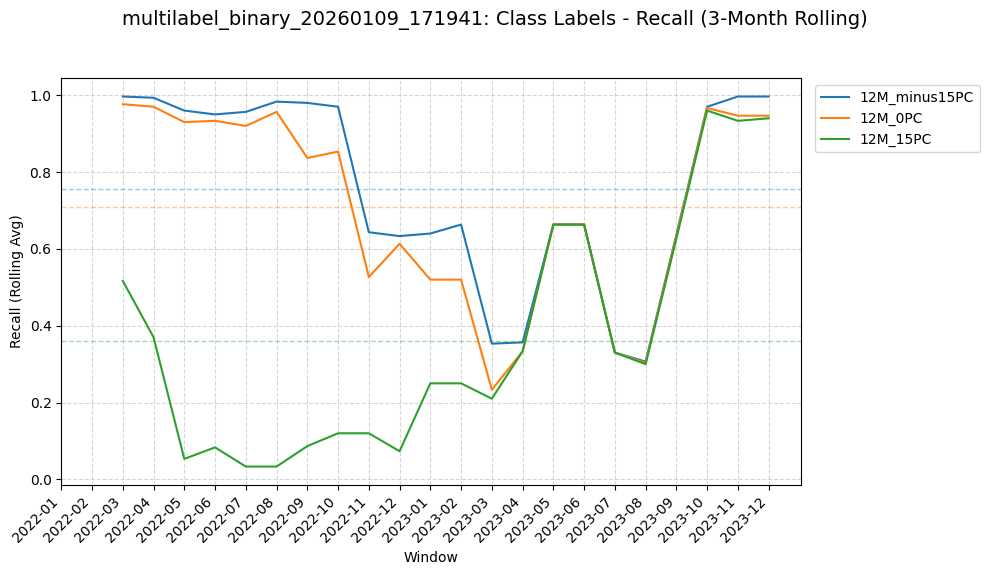

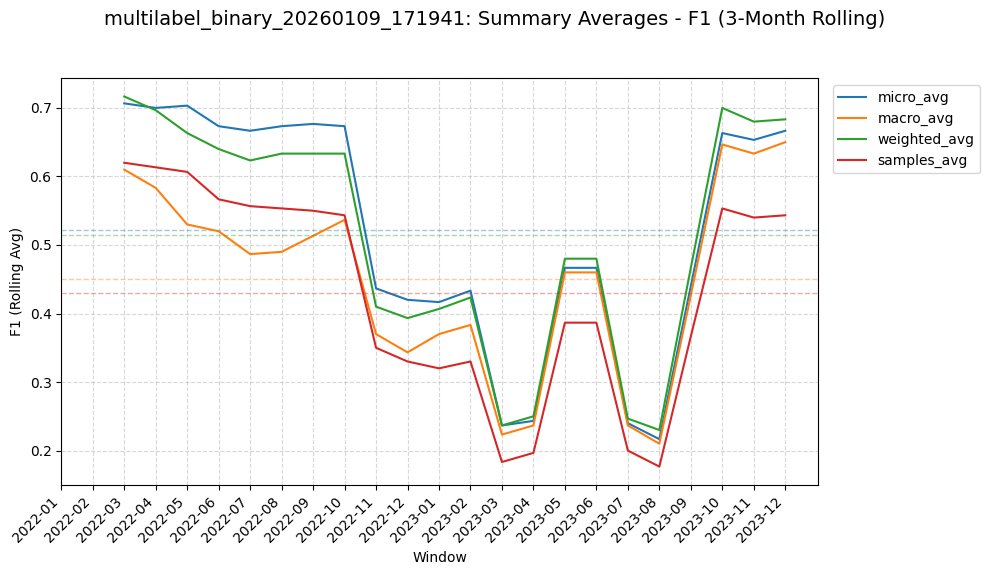

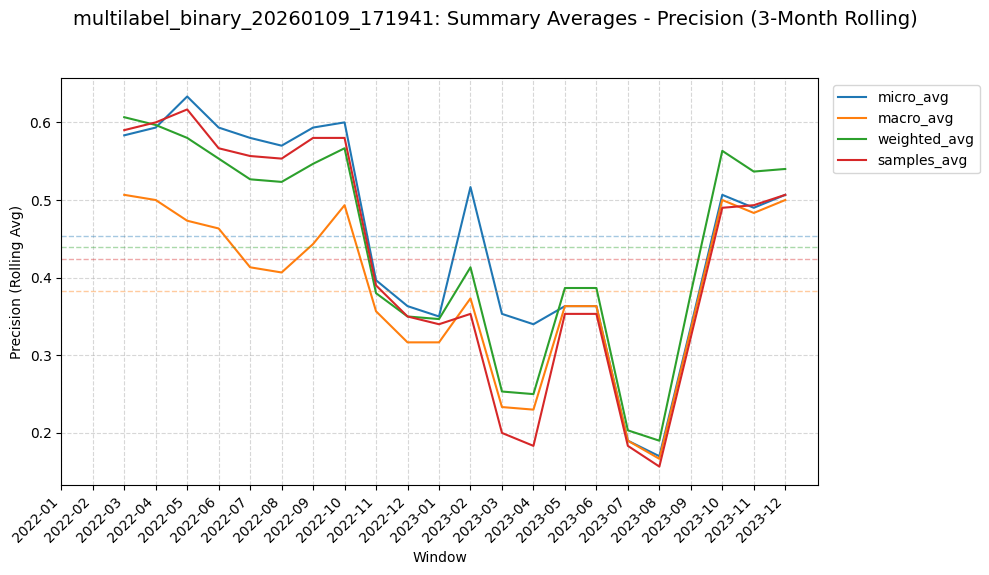

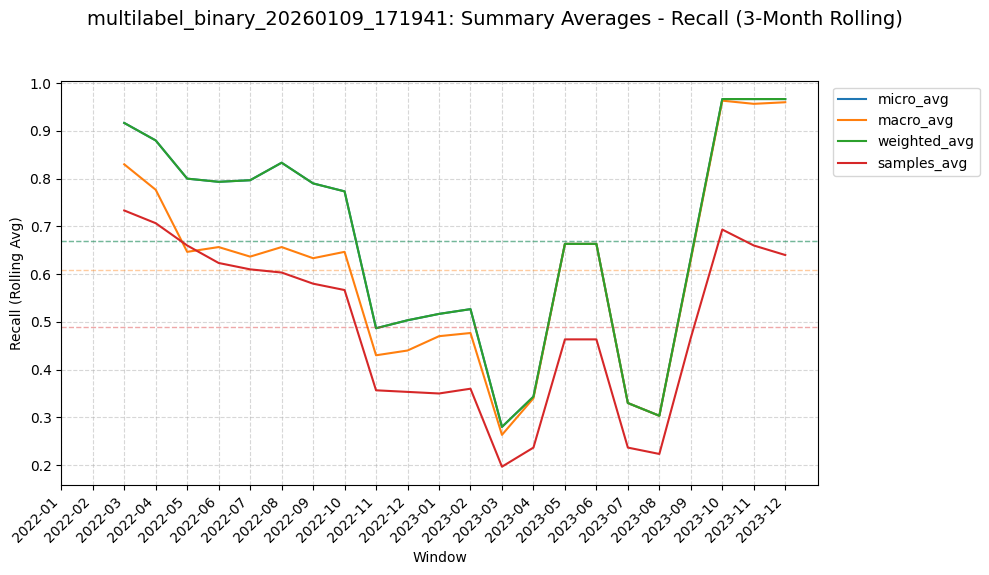

FILE: multilabel_binary_20260109_184339.txt
Saved CSV to: multilabel_binary_20260109_184339.csv (24 rows)


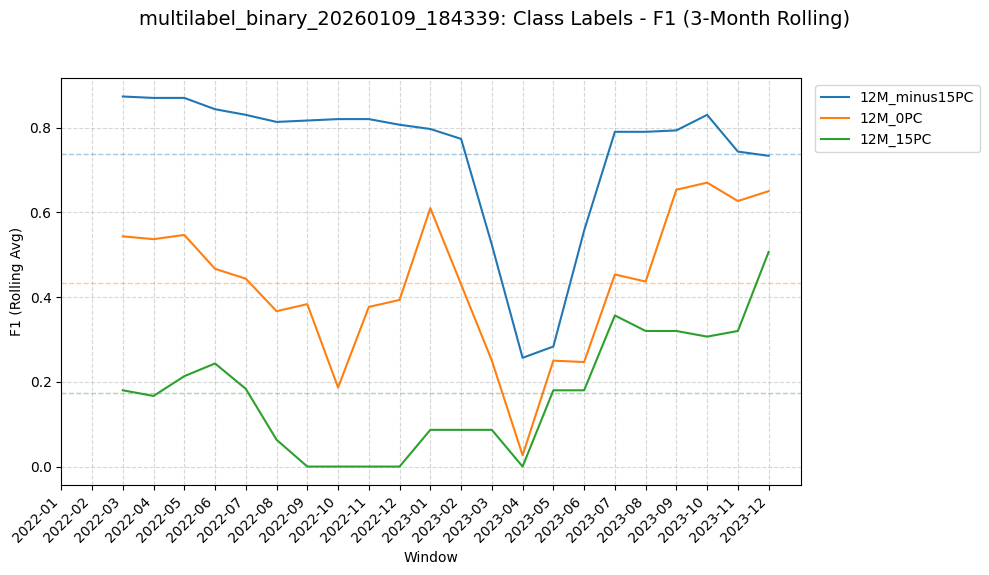

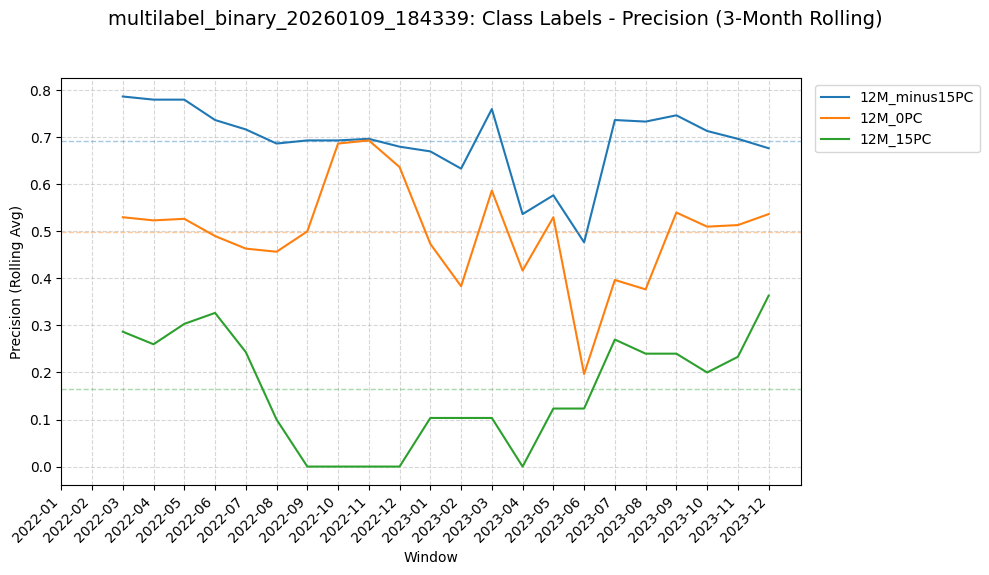

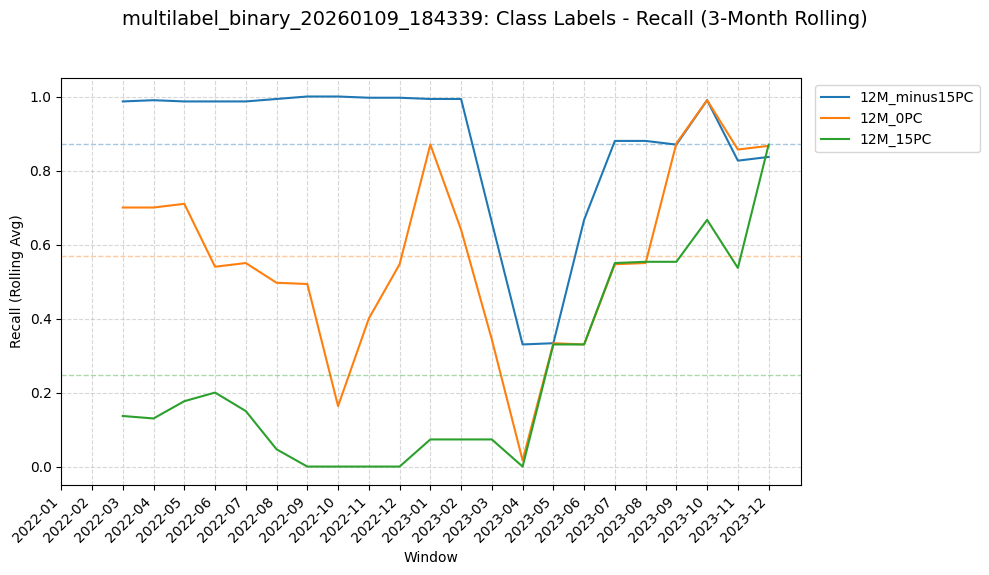

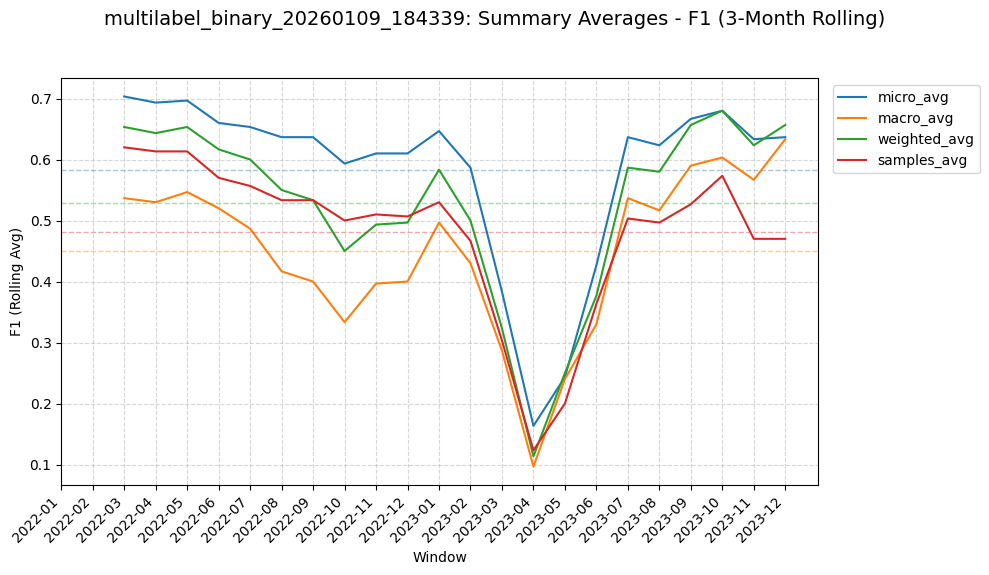

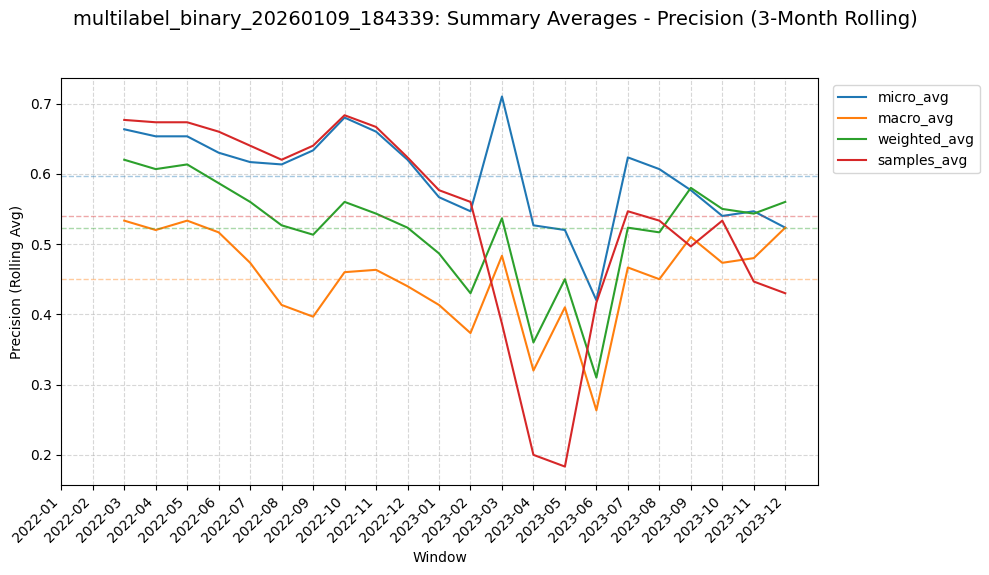

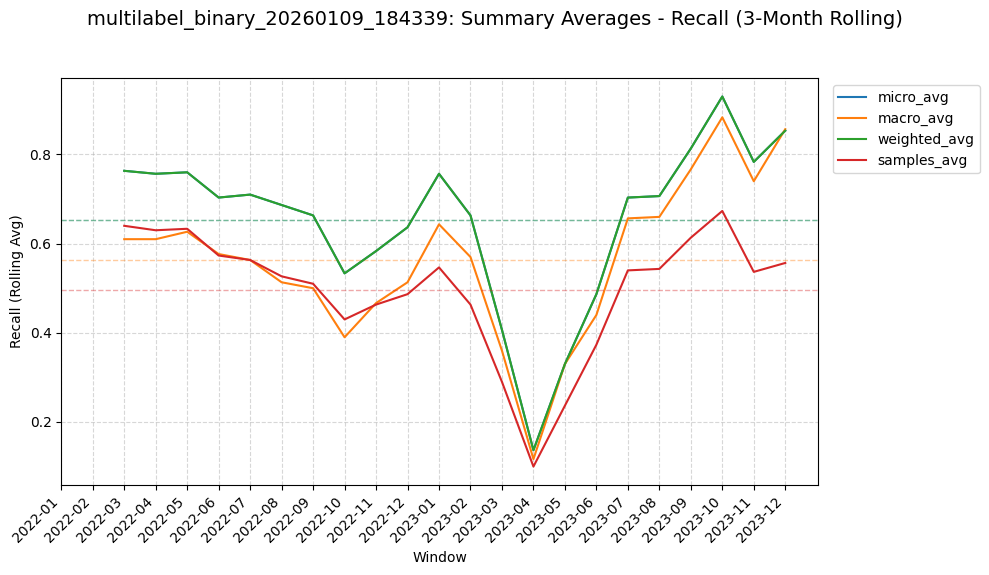

[SKIP] No valid data found in: multilabel_binary_20260110_004936.txt
FILE: multilabel_binary_20260110_005208.txt
Saved CSV to: multilabel_binary_20260110_005208.csv (12 rows)


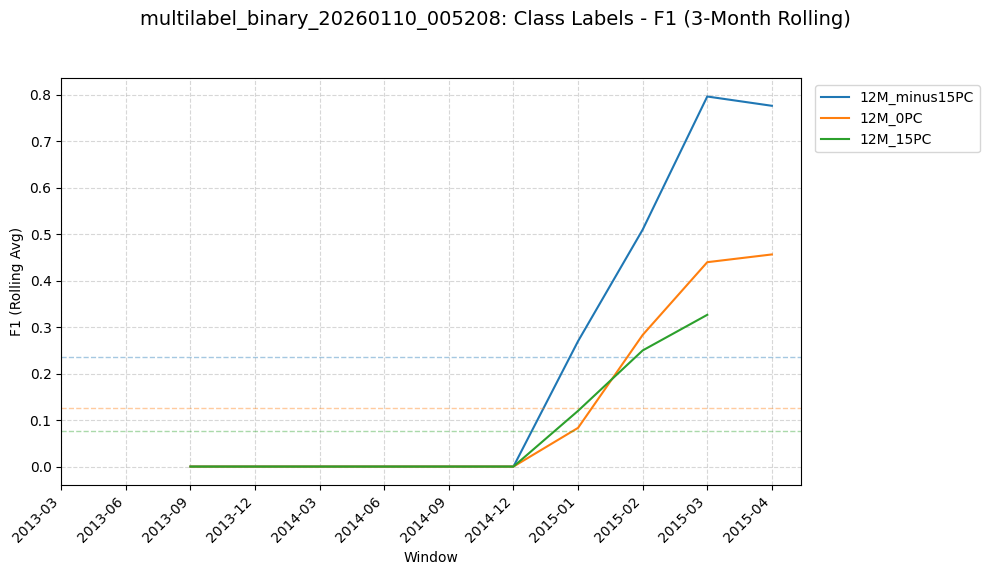

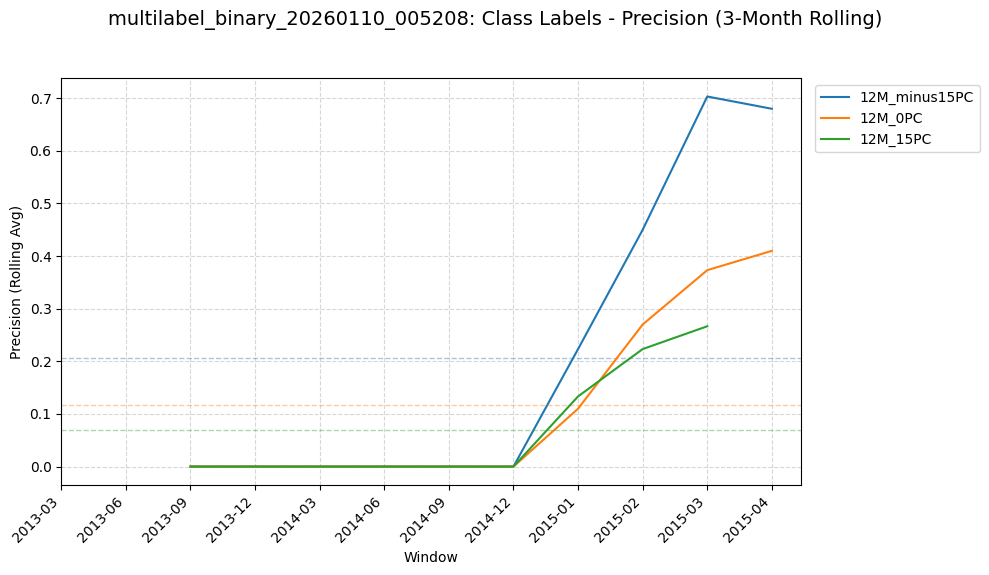

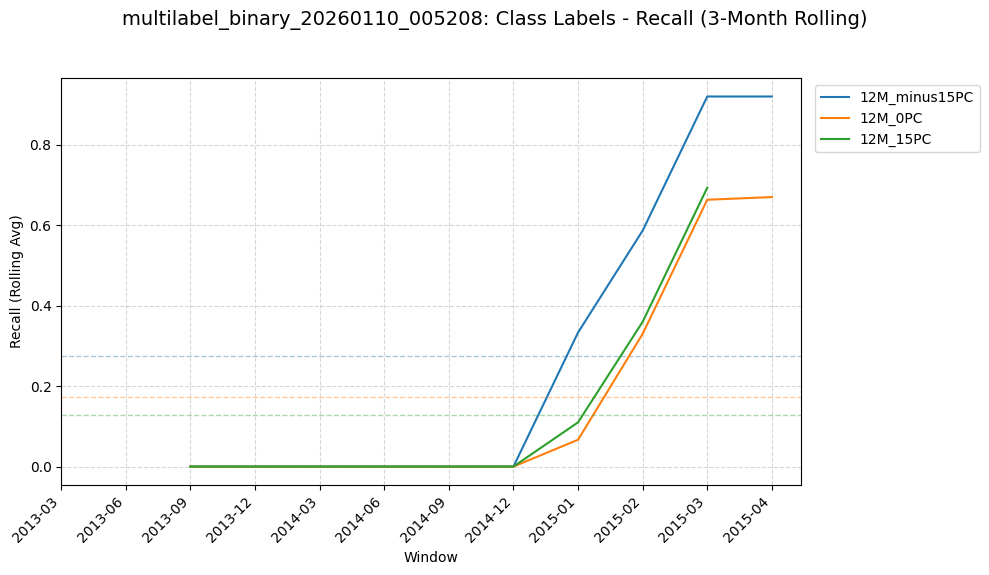

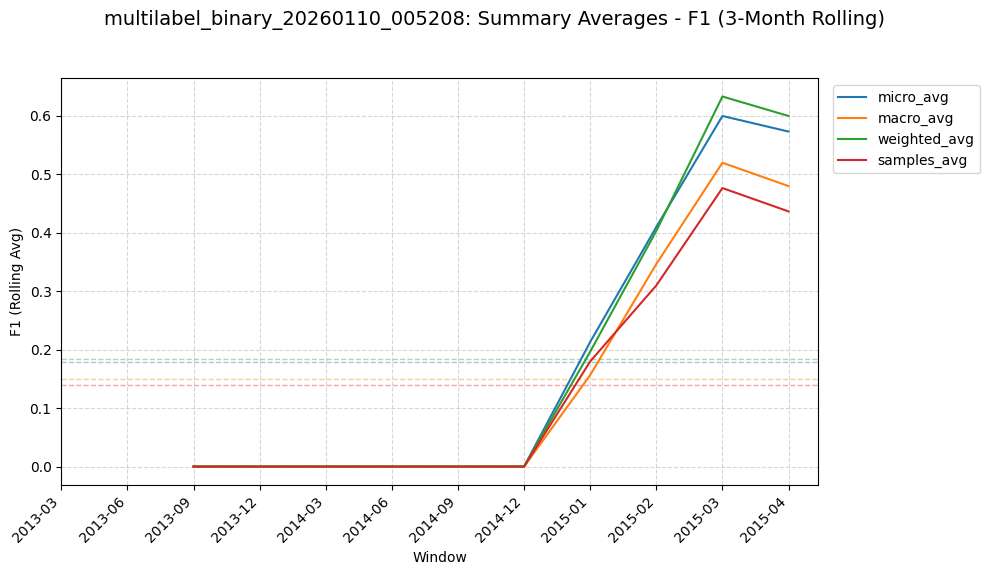

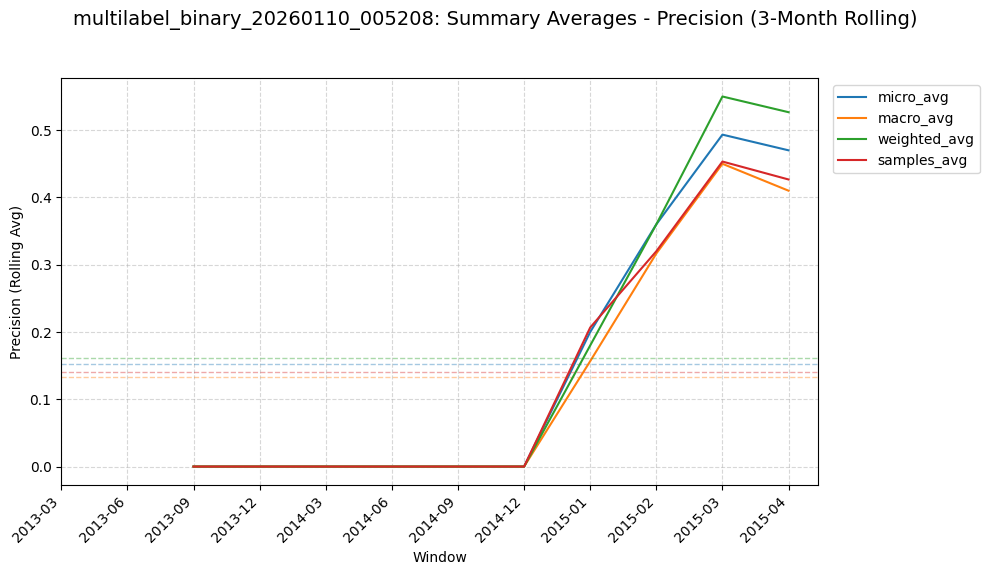

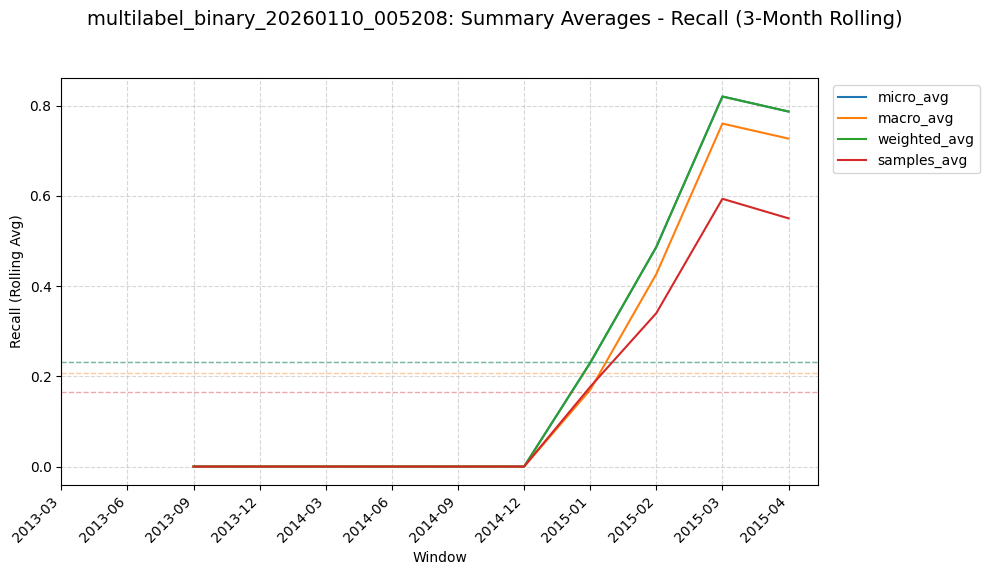

FILE: multilabel_binary_20260110_012532.txt
Saved CSV to: multilabel_binary_20260110_012532.csv (45 rows)


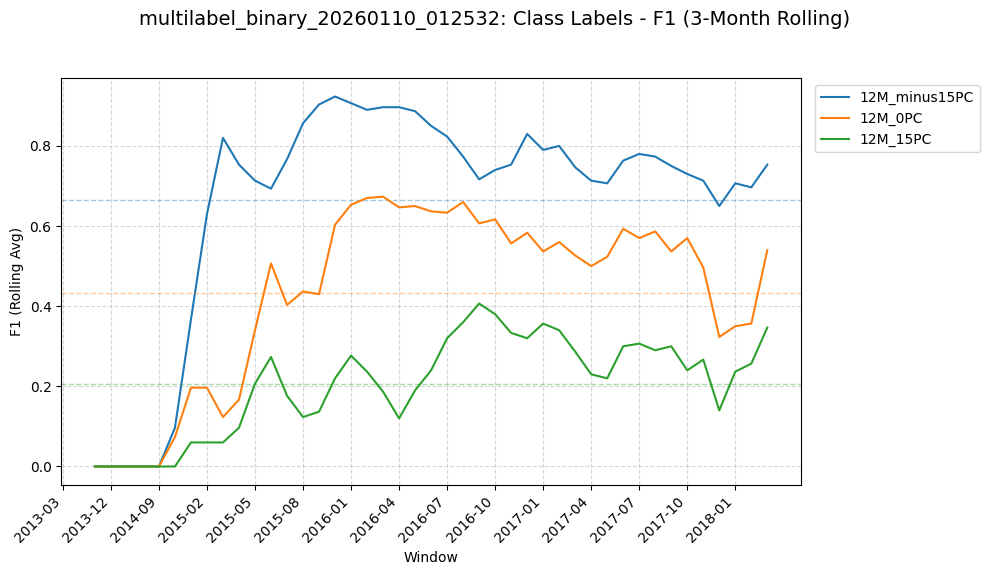

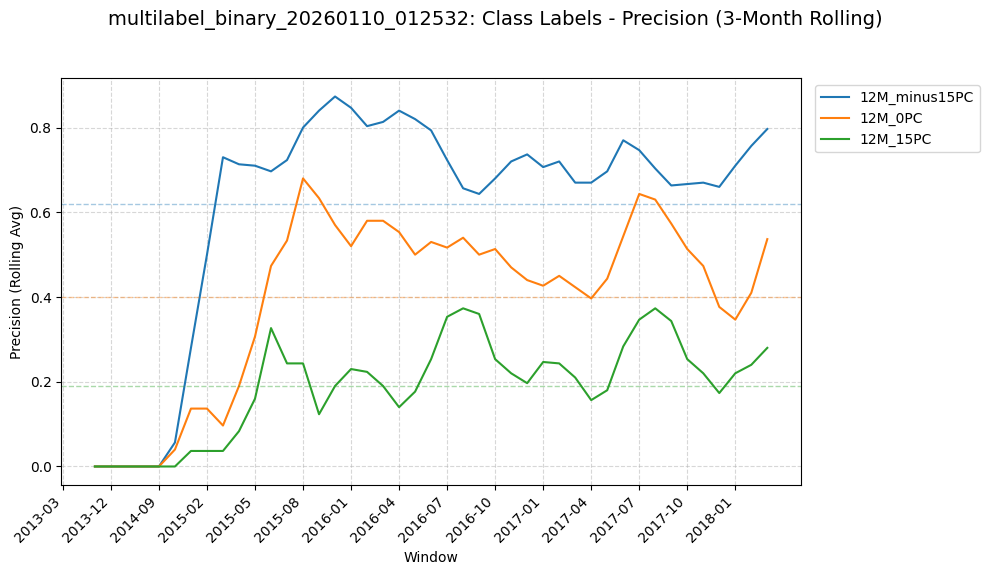

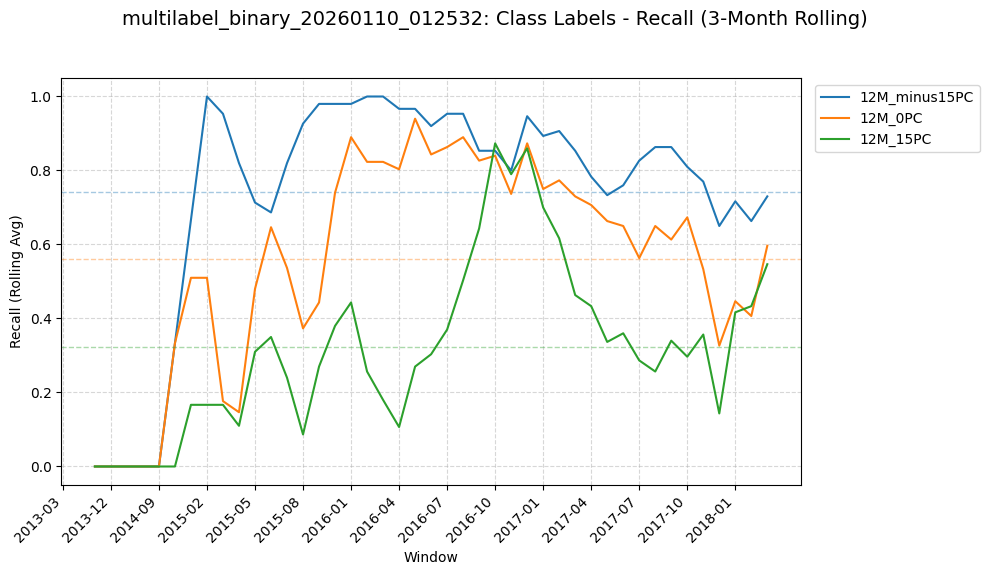

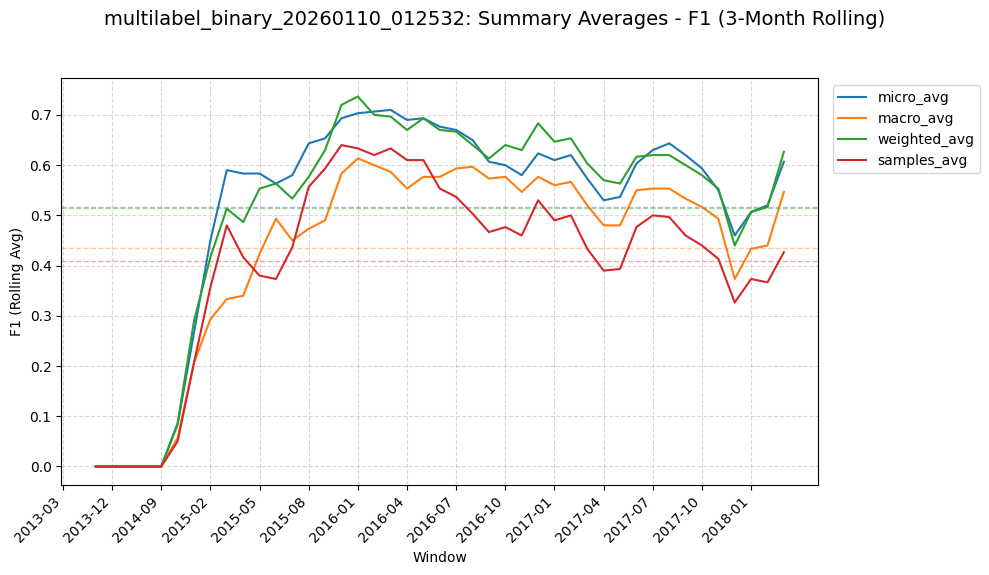

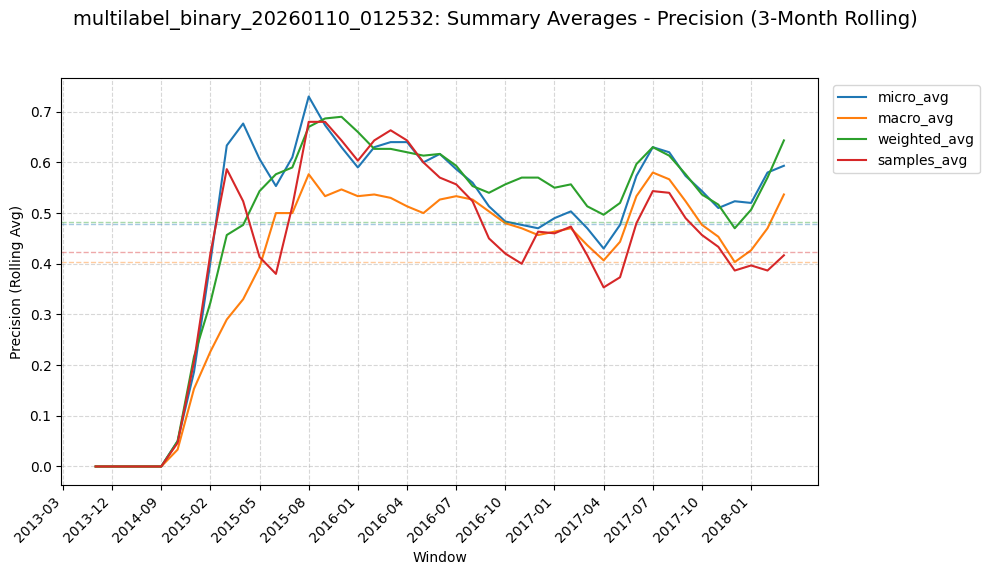

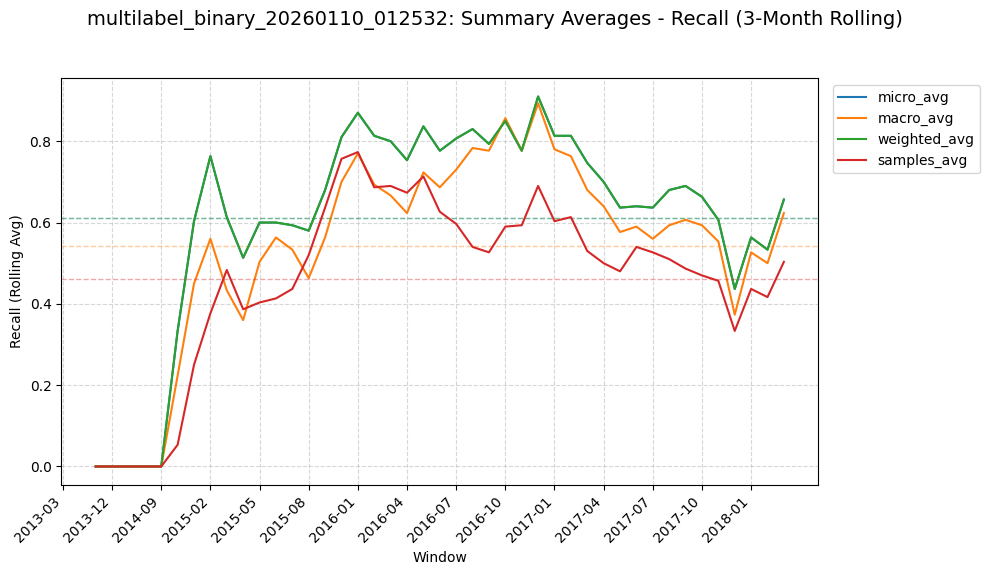

FILE: multilabel_binary_20260110_013116.txt
Saved CSV to: multilabel_binary_20260110_013116.csv (119 rows)


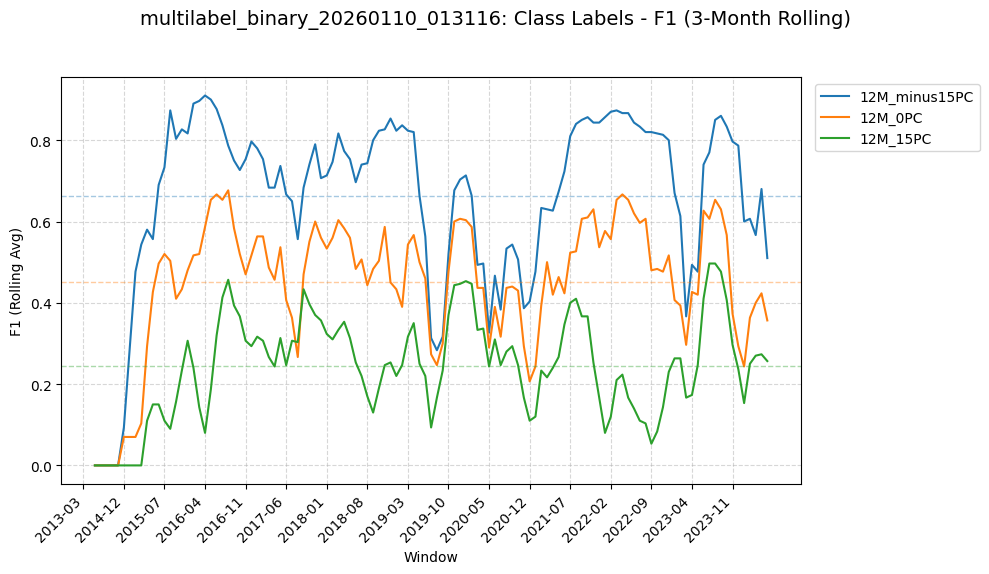

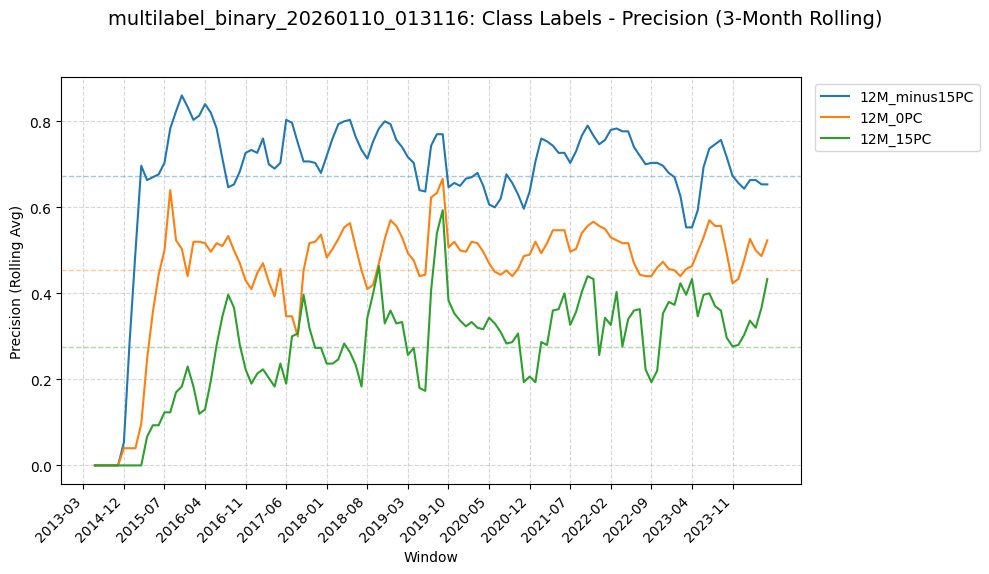

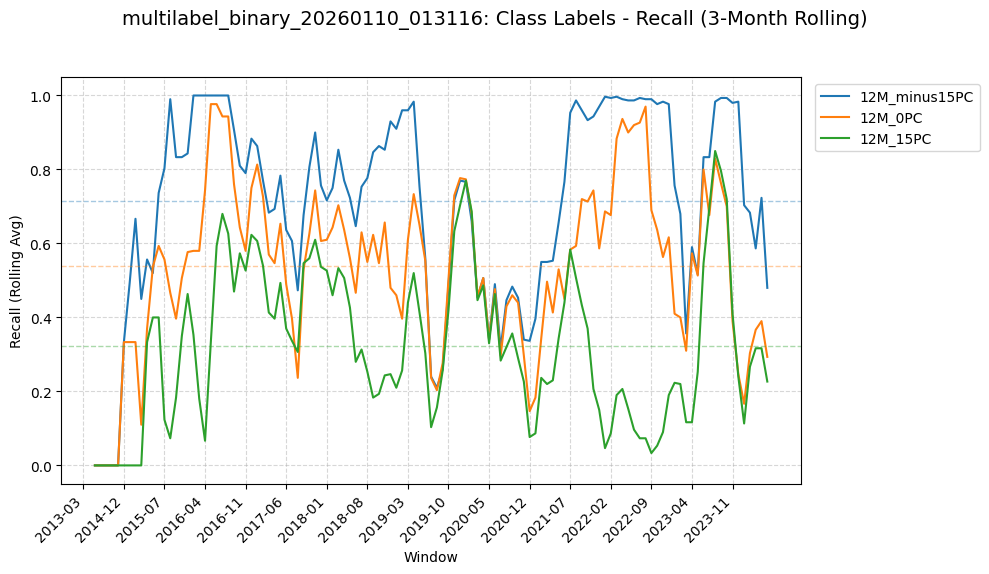

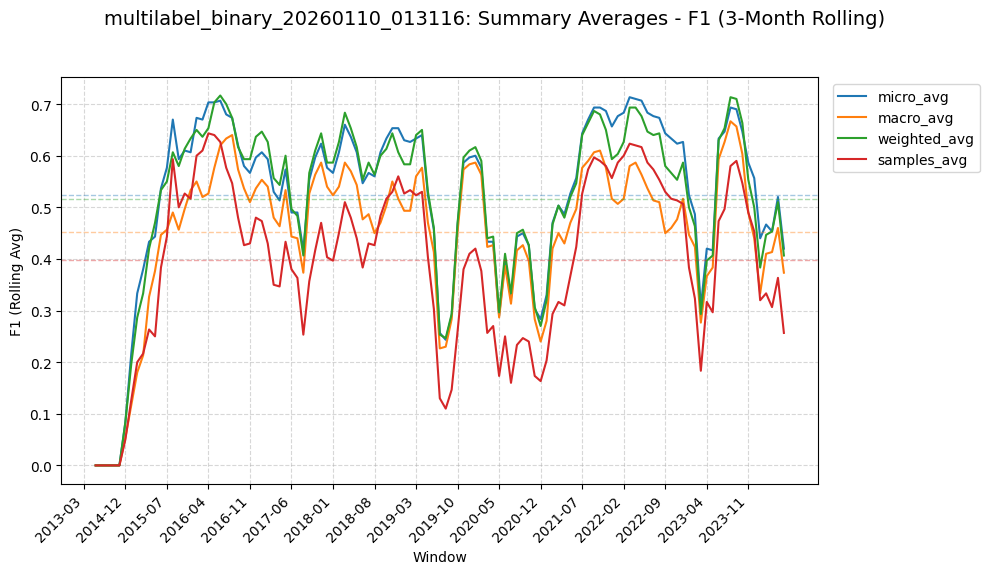

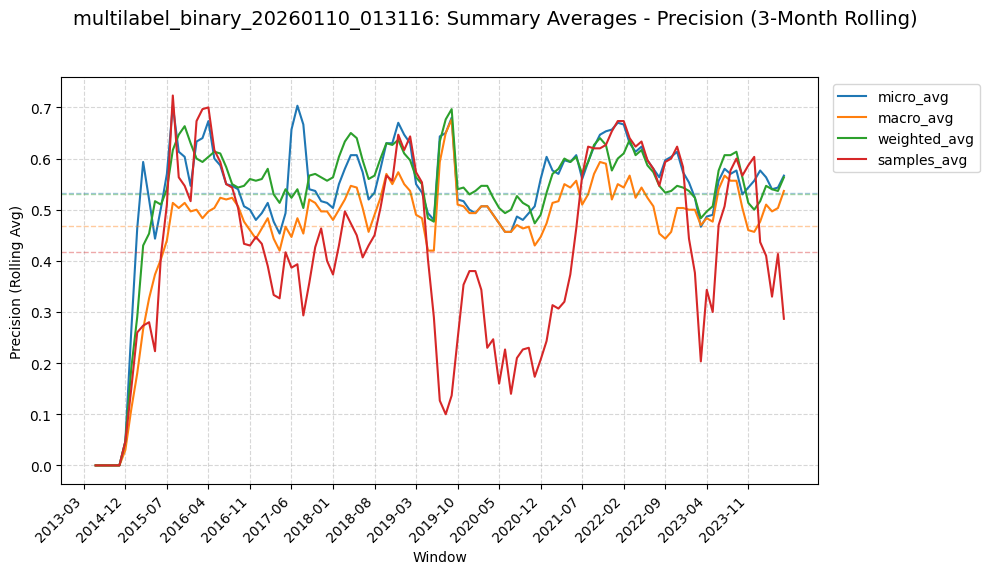

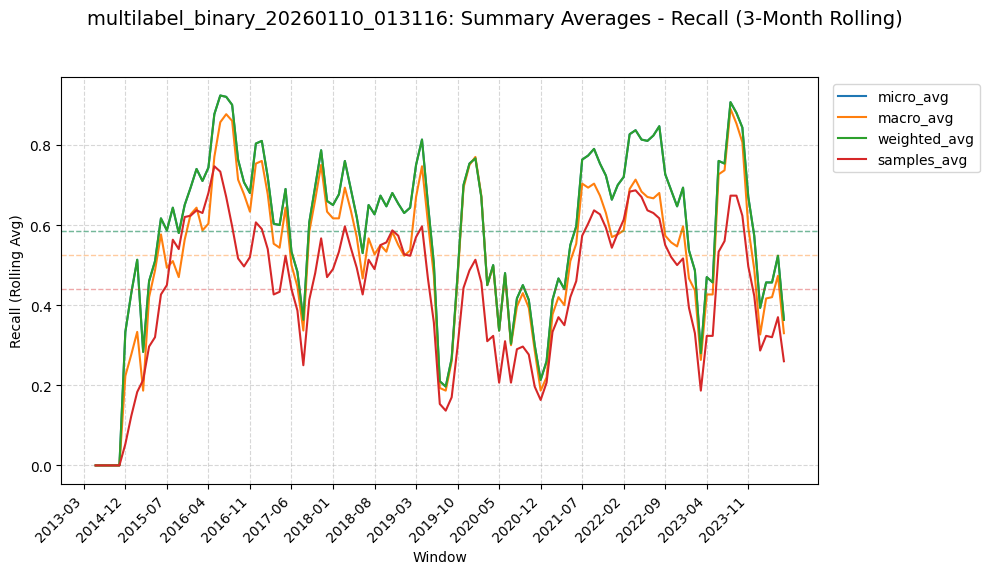

FILE: multilabel_binary_20260112_023152.txt
Saved CSV to: multilabel_binary_20260112_023152.csv (24 rows)


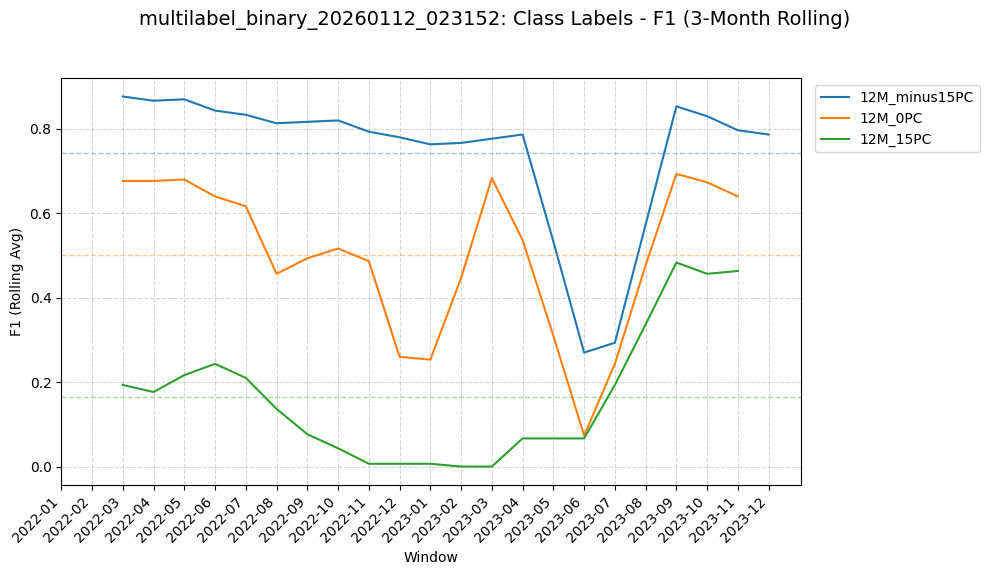

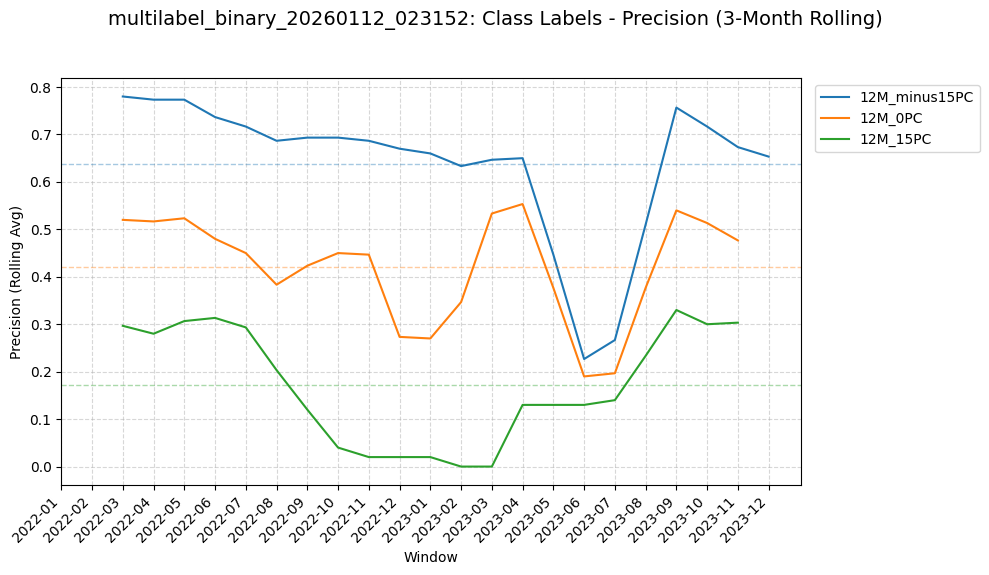

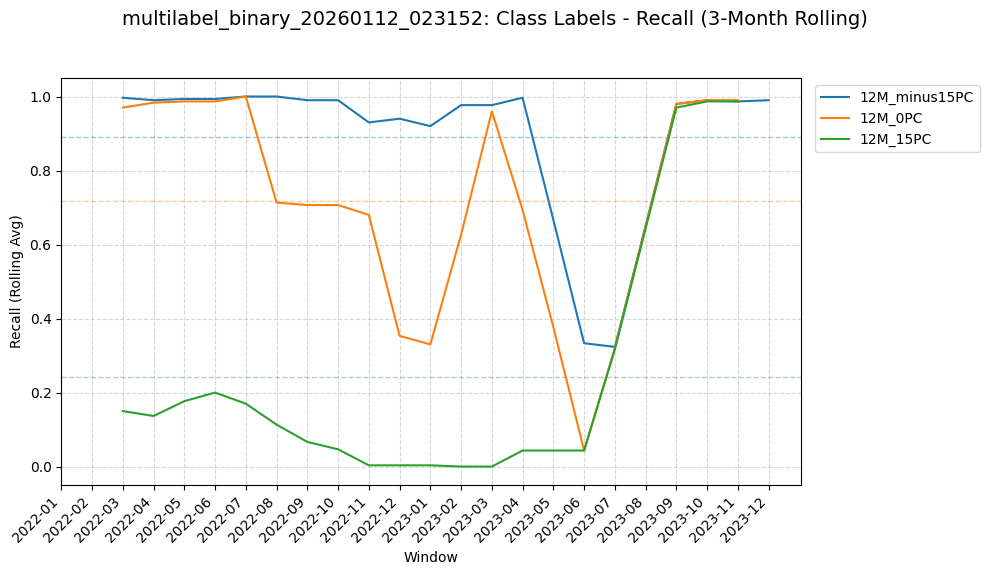

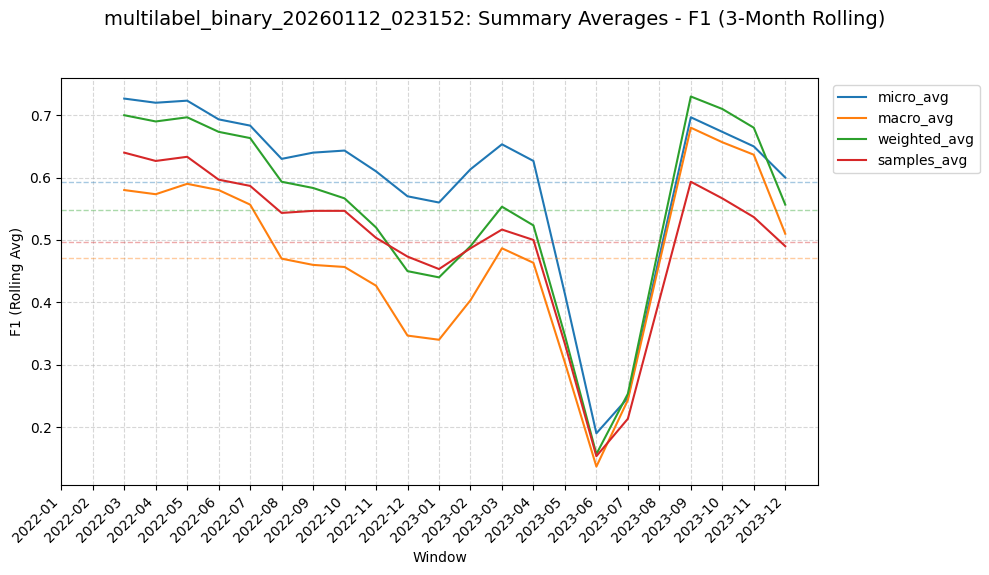

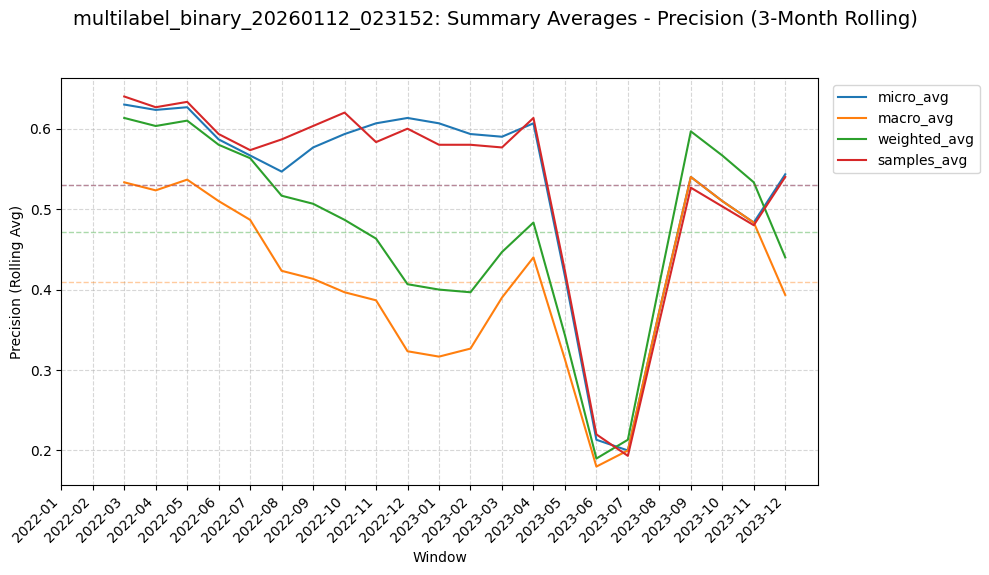

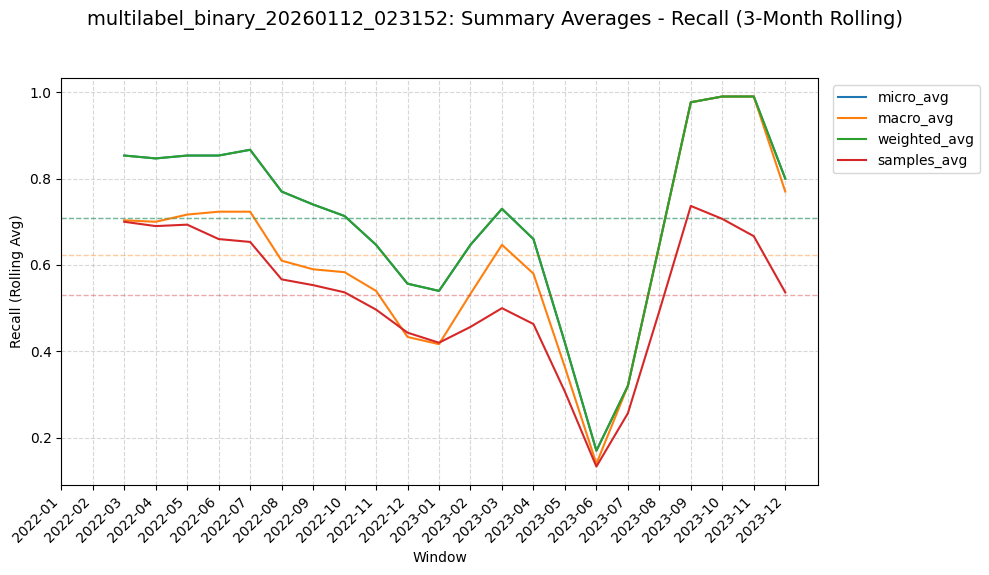

------------------------------
Processing complete. Processed 9 files.


In [16]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

# ==========================================
# USER CONFIGURATION
# ==========================================
INPUT_DIR = r"C:\Users\bnroo\OneDrive\Desktop\Algotrading\CongressTradingProj\logs\12M"
OUTPUT_DIR = r"C:\Users\bnroo\OneDrive\Desktop\Algotrading\CongressTradingProj\logs\12M"

# ==========================================
# SIMPLIFIED PARSING LOGIC
# ==========================================
def parse_log_content(content):
    """
    Parses log content using string splitting based on the fixed table format.
    No complex regex for table rows.
    """
    chunks = content.split('=== RETRAINING For Window:')
    extracted_data = []

    for chunk in chunks[1:]:
        record = {}
        
        # --- A. Extract Metadata (Window, Train, Test sizes) ---
        lines = chunk.strip().split('\n')
        
        header_line = lines[0].strip()
        record['window'] = header_line.split(' ')[0]

        for line in lines:
            if "Train:" in line and "Test:" in line:
                parts = line.split('|')
                for p in parts:
                    if "Train" in p:
                        record['train_size'] = int(p.split(':')[-1].strip())
                    elif "Gap" in p:
                        record['gap_size'] = int(p.split(':')[-1].strip())
                    elif "Test" in p:
                        record['test_size'] = int(p.split(':')[-1].strip())
                break
        
        # --- B. Find the Classification Table ---
        separator = "-" * 50
        if separator not in chunk:
            continue
            
        table_section = chunk.split(separator)[1]
        table_lines = table_section.strip().split('\n')
        
        for line in table_lines:
            line = line.strip()
            if not line: continue
            if "precision" in line and "recall" in line: continue

            parts = line.split()
            if len(parts) < 5: 
                continue

            try:
                support = int(parts[-1])
                f1 = float(parts[-2])
                recall = float(parts[-3])
                precision = float(parts[-4])
                
                label_parts = parts[:-4]
                raw_label = "_".join(label_parts)
                
                clean_label = raw_label.replace('avg', '_avg') if 'avg' in raw_label else raw_label
                clean_label = clean_label.replace('__', '_').strip('_')

                record[f'{clean_label}_precision'] = precision
                record[f'{clean_label}_recall']    = recall
                record[f'{clean_label}_f1']        = f1
                record[f'{clean_label}_support']   = support
                
            except ValueError:
                continue

        extracted_data.append(record)

    return extracted_data

def display_split_charts(df, title_prefix):
    """
    Plots separate figures for each metric (F1, Precision, Recall).
    - Cuts off trailing zeroes (incomplete data).
    - Plots 3-month rolling averages.
    """
    if df.empty or 'window' not in df.columns:
        return

    # Identify columns ending in _f1 to find all categories
    f1_cols = [c for c in df.columns if c.endswith('_f1')]
    all_categories = [c.replace('_f1', '') for c in f1_cols]

    # Split into 'Averages' vs 'Real Labels'
    avg_keywords = ['micro', 'macro', 'weighted', 'samples']
    avg_labels = [l for l in all_categories if any(k in l.lower() for k in avg_keywords)]
    class_labels = [l for l in all_categories if l not in avg_labels]

    # --- Plotting Helper ---
    def plot_group(labels_subset, group_title):
        if not labels_subset: return
        
        metrics = ['f1', 'precision', 'recall']
        n_rows = len(df)
        tick_step = max(1, n_rows // 15)
        
        for metric in metrics:
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Update title to reflect the new processing
            fig.suptitle(f"{title_prefix}: {group_title} - {metric.capitalize()} (3-Month Rolling)", fontsize=14)

            for label in labels_subset:
                col_name = f'{label}_{metric}'
                if col_name in df.columns:
                    # 1. Get valid data (drop NaNs)
                    valid = df.dropna(subset=[col_name]).copy()
                    
                    if valid.empty:
                        continue

                    # 2. Cut off trailing zeroes
                    # Find the index of the last non-zero value
                    non_zero_indices = valid.index[valid[col_name] != 0].tolist()
                    
                    if non_zero_indices:
                        last_valid_idx = non_zero_indices[-1]
                        # Slice data up to the last non-zero value
                        valid = valid.loc[:last_valid_idx]
                    else:
                        # If data is all zeroes, skip plotting or plot empty
                        continue

                    # 3. Apply 3-Month Rolling Average
                    # Note: First 2 points will become NaN
                    valid[col_name] = valid[col_name].rolling(window=3).mean()

                    # Plot the rolling data
                    line, = ax.plot(valid['window'], valid[col_name], label=label, linewidth=1.5)

                    # Add average line (based on the rolled data)
                    # Use dropna again because rolling() introduced NaNs at the start
                    clean_rolled = valid[col_name].dropna()
                    if not clean_rolled.empty:
                        avg_val = clean_rolled.mean()
                        ax.axhline(y=avg_val, color=line.get_color(), linestyle='--', alpha=0.4, linewidth=1)
            
            ax.set_ylabel(f"{metric.capitalize()} (Rolling Avg)")
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

            ax.set_xlabel('Window')
            
            # Handle X-axis ticks using the original DF to keep spacing consistent, 
            # even if some lines are shorter due to trimming
            if n_rows > 0:
                indices_to_show = list(range(0, n_rows, tick_step))
                labels_to_show = df['window'].iloc[indices_to_show]
                
                ax.set_xticks(indices_to_show)
                ax.set_xticklabels(labels_to_show, rotation=45, ha='right')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    if class_labels:
        plot_group(class_labels, "Class Labels")
    
    if avg_labels:
        plot_group(avg_labels, "Summary Averages")

# ==========================================
# MAIN EXECUTION
# ==========================================

os.makedirs(OUTPUT_DIR, exist_ok=True)
files = glob.glob(os.path.join(INPUT_DIR, "*.txt"))

print(f"Scanning: {INPUT_DIR}")
print(f"Found {len(files)} log files.\n")

files_processed = 0

for filepath in files:
    filename = os.path.basename(filepath)
    base_name = os.path.splitext(filename)[0]
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # 1. Parse
        data = parse_log_content(content)
        
        if data:
            df = pd.DataFrame(data)

            # 2. Reorder columns (Window first)
            cols = list(df.columns)
            if 'window' in cols:
                cols.insert(0, cols.pop(cols.index('window')))
            df = df[cols]

            # 3. Save CSV
            csv_filename = f"{base_name}.csv"
            output_path = os.path.join(OUTPUT_DIR, csv_filename)
            df.to_csv(output_path, index=False)
            
            print("="*60)
            print(f"FILE: {filename}")
            print(f"Saved CSV to: {csv_filename} ({len(df)} rows)")
            
            # 4. Display Charts (Now with Rolling Avg & Zero Trimming)
            display_split_charts(df, base_name)
            
            files_processed += 1
        else:
            print(f"[SKIP] No valid data found in: {filename}")
            
    except Exception as e:
        print(f"[ERROR] Could not process {filename}: {e}")

print("-" * 30)
print(f"Processing complete. Processed {files_processed} files.")

Calculate total performance metrics from monthly metrics

Successfully loaded data: 112 rows found.

==================== Aggregate Performance Plots ====================


C:\Users\bnroo\AppData\Local\Temp\ipykernel_4004\3524048184.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['window'] = pd.to_datetime(df_clean['window'])


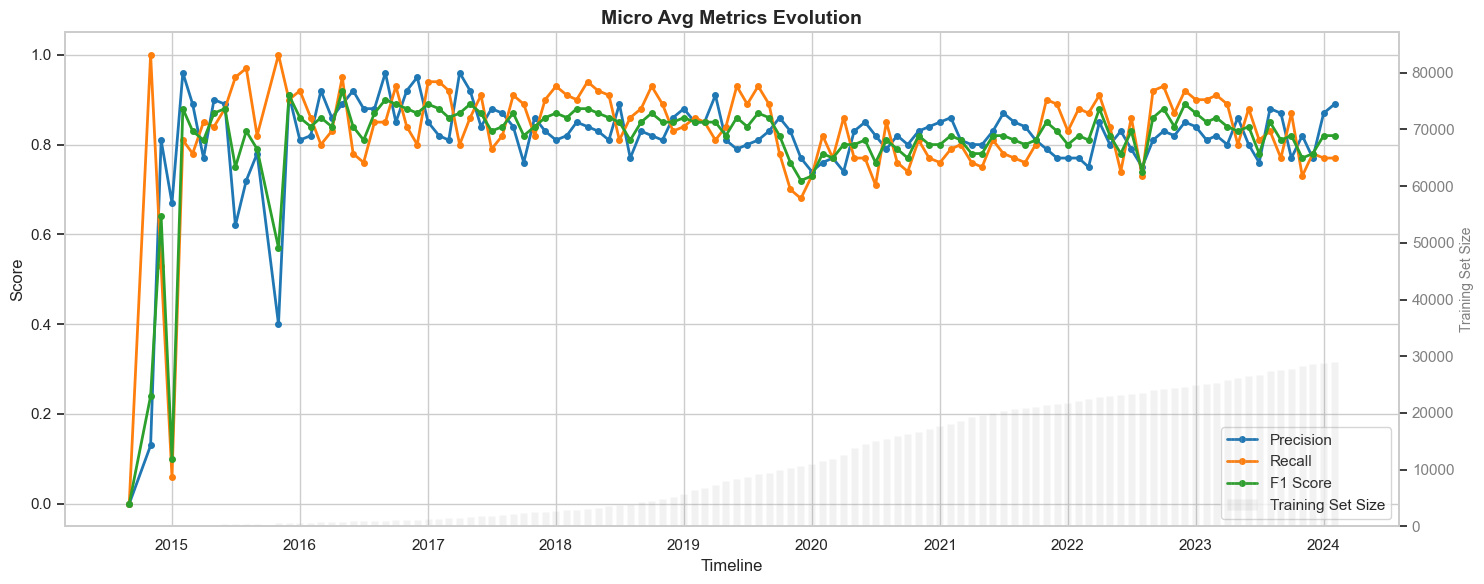

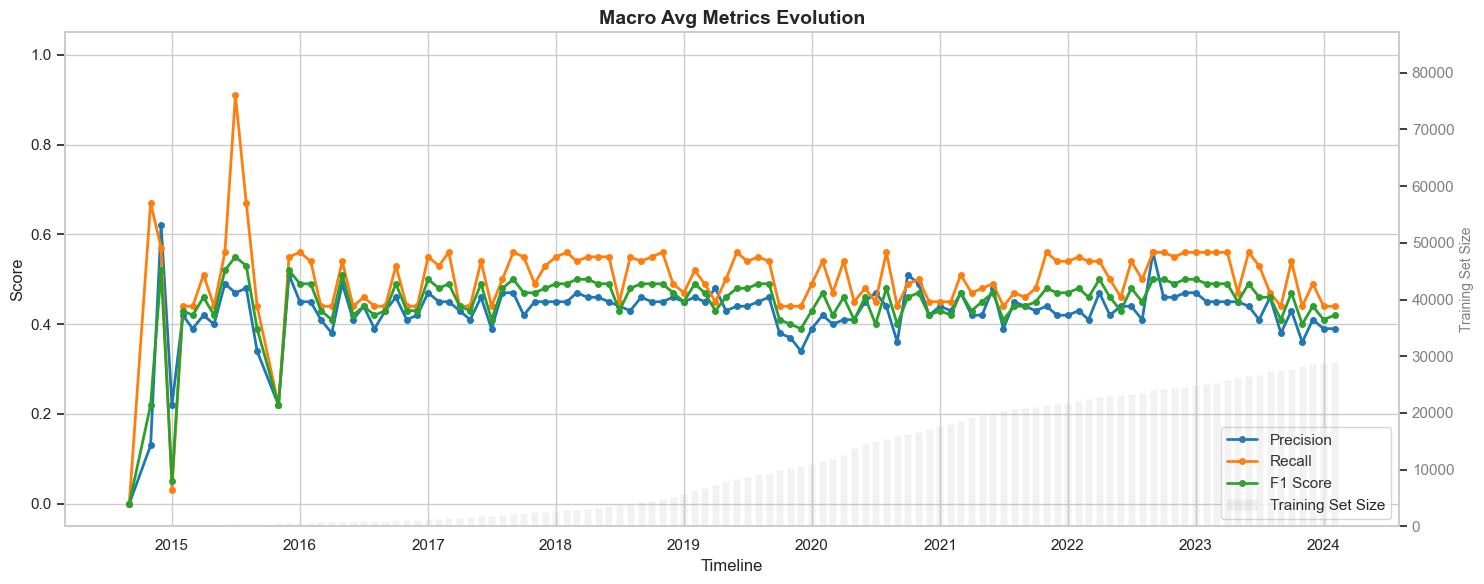

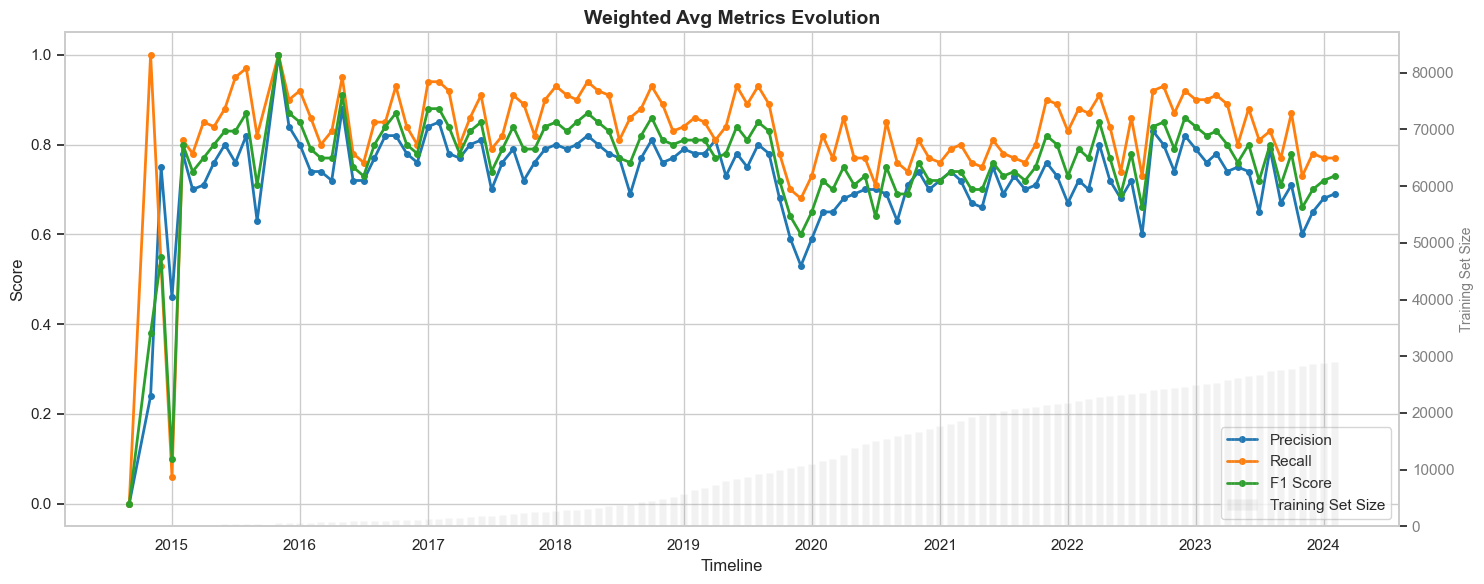

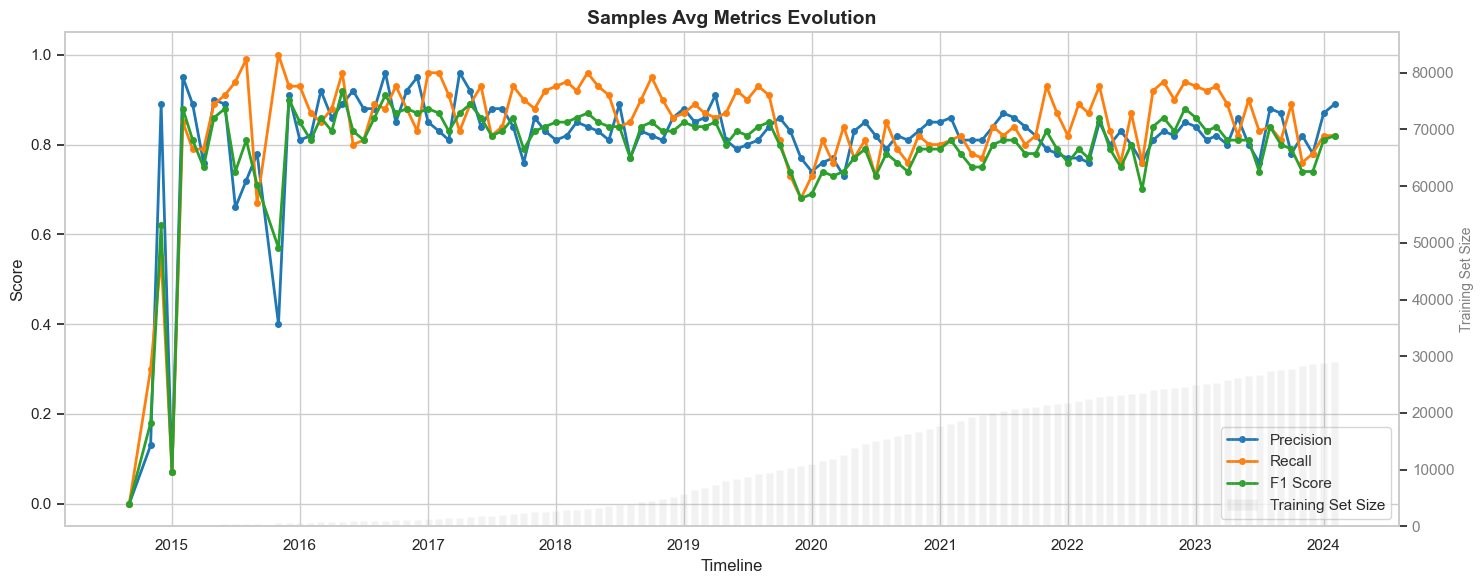


==================== Individual Label Comparisons ====================
Comparing 9 labels (Original Order): ['minus16PC', 'minus12PC', 'minus8PC', 'minus4PC', '0PC', '4PC', '8PC', '12PC', '16PC']


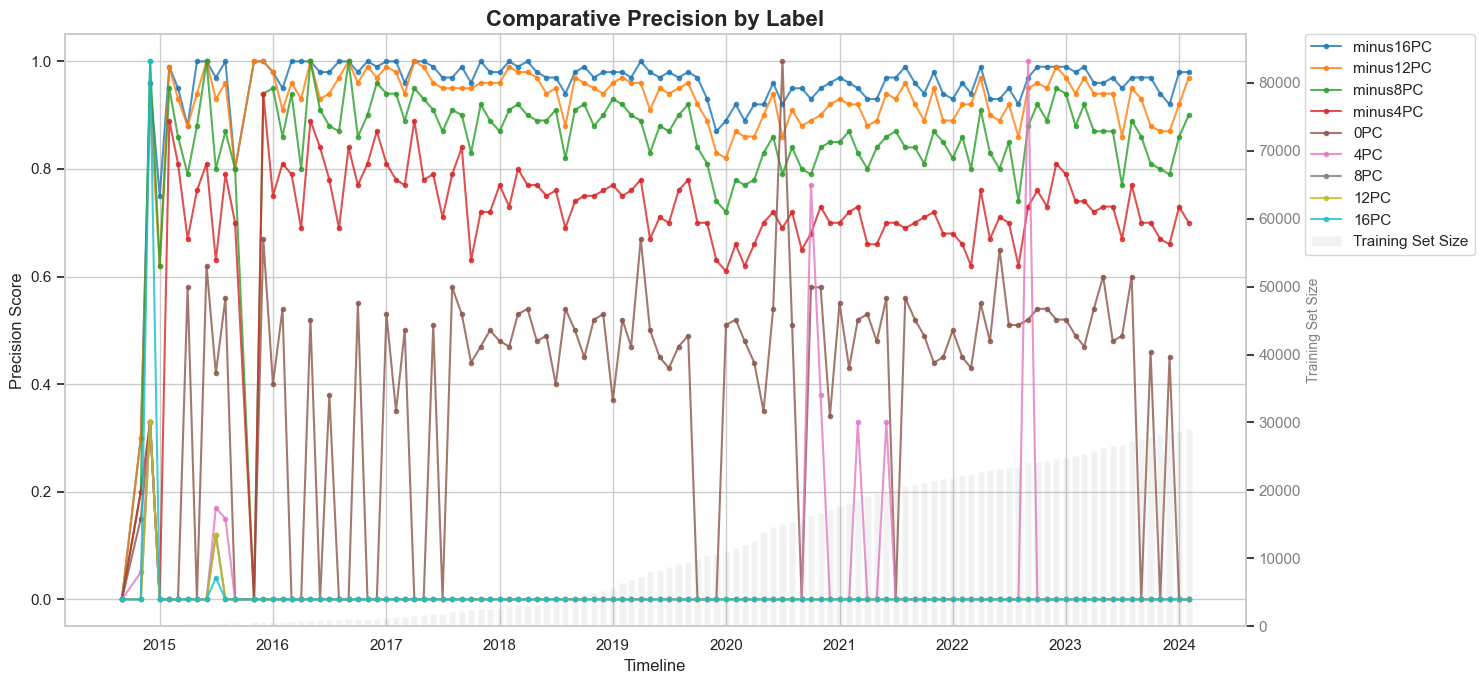

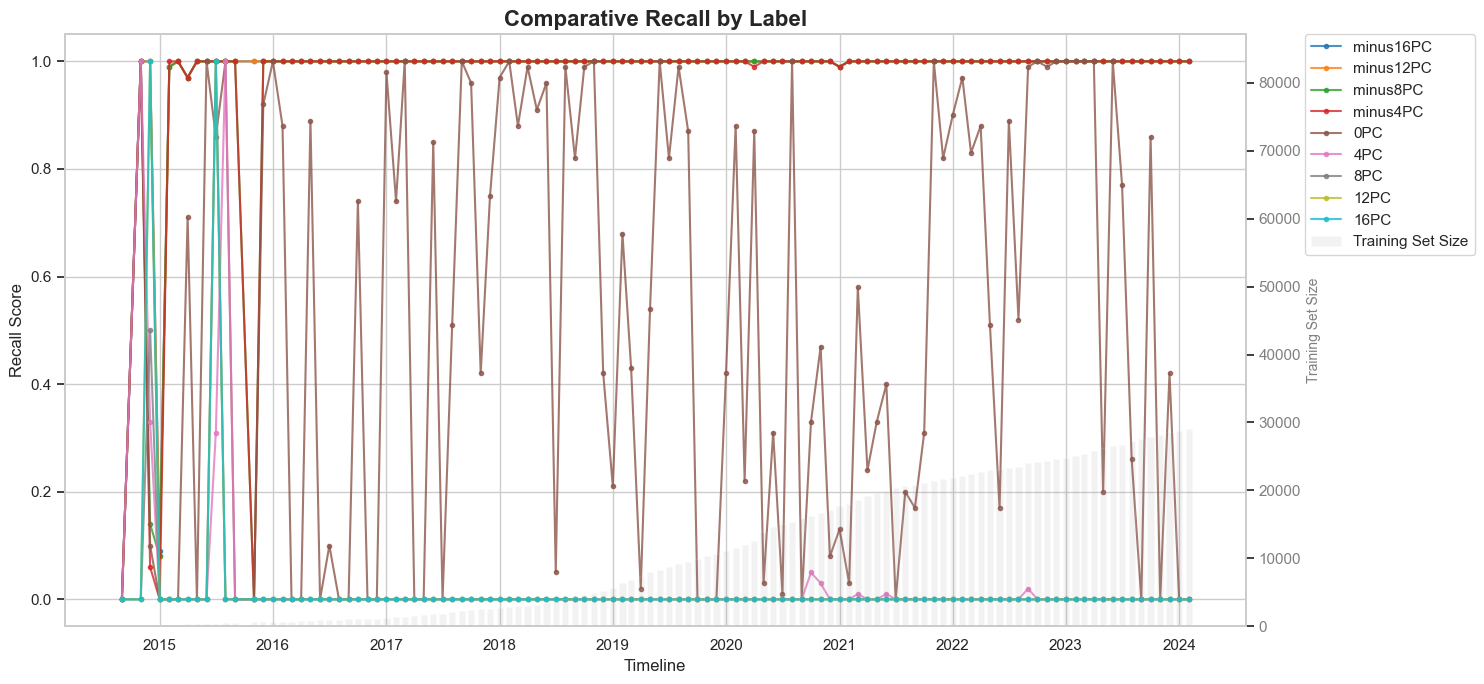

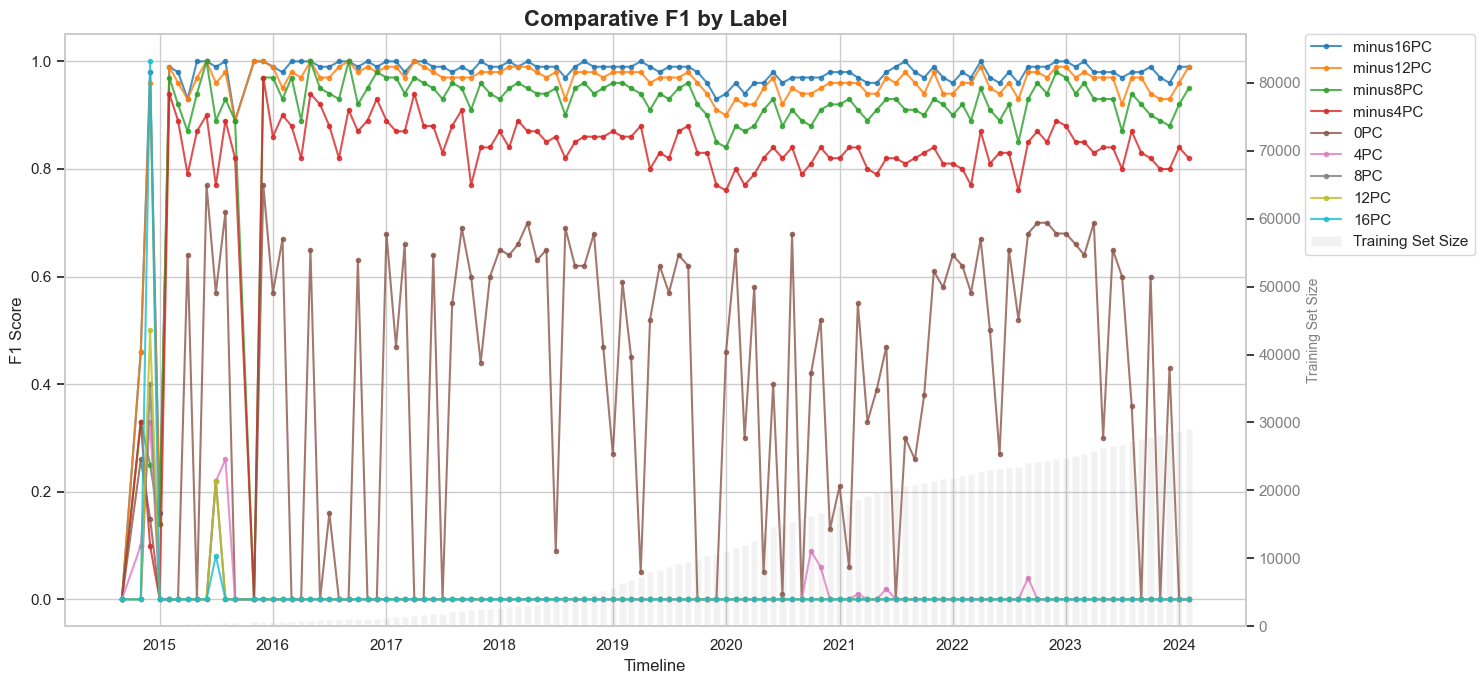

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np
from IPython.display import display

def analyze_performance_complete(file_path):
    # 1. Load Data
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data: {len(df)} rows found.")
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    # 2. Preprocessing
    metric_cols = [c for c in df.columns if any(x in c for x in ['precision', 'recall', 'f1'])]
    df_clean = df.dropna(subset=metric_cols).copy()
    
    df_clean['window'] = pd.to_datetime(df_clean['window'])
    df_clean['Year'] = df_clean['window'].dt.year
    
    # Determine volume column
    if 'train_size' in df.columns:
        vol_col = 'train_size'
        vol_label = 'Training Set Size'
    elif 'test_size' in df.columns:
        vol_col = 'test_size'
        vol_label = 'Test Set Size'
    else:
        vol_col = 'result_count'
        vol_label = 'Result Count'

    # 3. Dynamic Column Identification (Preserving Order)
    all_f1_cols = [c for c in df_clean.columns if c.endswith('_f1')]
    all_prefixes = [c.replace('_f1', '') for c in all_f1_cols]
    
    # Define standard averages
    # We list them explicitly to ensure we look for them specifically
    standard_avgs_list = ['micro_avg', 'macro_avg', 'weighted_avg', 'samples_avg']
    
    # Identify individual labels (anything in the file that isn't a standard average)
    # Preservation of order comes from 'all_prefixes' which matches CSV column order
    individual_labels = [p for p in all_prefixes if p not in standard_avgs_list]
    
    # Identify which averages actually exist in this file
    avgs_present = [p for p in standard_avgs_list if p in all_prefixes]

    sns.set_theme(style="whitegrid")

    # ==============================================================================
    # PART A: Aggregate Performance (Micro, Macro, Weighted)
    # Plots Precision vs Recall vs F1 for a SINGLE average type
    # ==============================================================================
    print(f"\n{'='*20} Aggregate Performance Plots {'='*20}")
    
    for group in avgs_present:
        prec_col = f"{group}_precision"
        rec_col = f"{group}_recall"
        f1_col = f"{group}_f1"
        
        fig, ax1 = plt.subplots(figsize=(15, 6))
        
        # --- Background Volume ---
        if vol_col and vol_col in df_clean.columns:
            ax2 = ax1.twinx()
            ax2.bar(df_clean['window'], df_clean[vol_col], color='grey', alpha=0.10, width=20, label=vol_label)
            ax2.set_ylabel(vol_label, color='grey', fontsize=10)
            ax2.grid(False)
            max_vol = df_clean[vol_col].max()
            if pd.notna(max_vol) and max_vol > 0:
                ax2.set_ylim(0, max_vol * 3)
            ax2.tick_params(axis='y', labelcolor='grey')

        # --- Metric Lines ---
        ax1.plot(df_clean['window'], df_clean[prec_col], label='Precision', color='#1f77b4', marker='o', markersize=4, linewidth=2)
        ax1.plot(df_clean['window'], df_clean[rec_col], label='Recall', color='#ff7f0e', marker='o', markersize=4, linewidth=2)
        ax1.plot(df_clean['window'], df_clean[f1_col], label='F1 Score', color='#2ca02c', marker='o', markersize=4, linewidth=2)
        
        # Formatting
        ax1.set_title(f'{group.replace("_", " ").title()} Metrics Evolution', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Timeline', fontsize=12)
        ax1.set_ylabel('Score', fontsize=12)
        ax1.set_ylim(-0.05, 1.05)
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        # Legend
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        if vol_col and vol_col in df_clean.columns:
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right')
        else:
            ax1.legend(loc='lower right')
            
        plt.tight_layout()
        plt.show()

    # ==============================================================================
    # PART B: Individual Label Comparison
    # Plots All Labels for a SINGLE metric (e.g. Precision of Label A vs Label B)
    # ==============================================================================
    print(f"\n{'='*20} Individual Label Comparisons {'='*20}")
    print(f"Comparing {len(individual_labels)} labels (Original Order): {individual_labels}")

    metrics_to_plot = ['precision', 'recall', 'f1']
    
    # Generate colors based on original order
    colors = cm.tab10(np.linspace(0, 1, len(individual_labels))) if len(individual_labels) <= 10 else cm.nipy_spectral(np.linspace(0, 1, len(individual_labels)))
    label_color_map = dict(zip(individual_labels, colors))

    for metric in metrics_to_plot:
        fig, ax1 = plt.subplots(figsize=(15, 7))
        
        # --- Background Volume ---
        if vol_col and vol_col in df_clean.columns:
            ax2 = ax1.twinx()
            ax2.bar(df_clean['window'], df_clean[vol_col], color='grey', alpha=0.10, width=20, label=vol_label)
            ax2.set_ylabel(vol_label, color='grey', fontsize=10)
            ax2.grid(False)
            max_vol = df_clean[vol_col].max()
            if pd.notna(max_vol) and max_vol > 0:
                ax2.set_ylim(0, max_vol * 3)
            ax2.tick_params(axis='y', labelcolor='grey')

        # --- Lines for Each Label ---
        lines = []
        labels = []
        
        for label_name in individual_labels:
            col_name = f"{label_name}_{metric}"
            if col_name in df_clean.columns:
                line, = ax1.plot(
                    df_clean['window'], 
                    df_clean[col_name], 
                    label=label_name, 
                    color=label_color_map[label_name], 
                    marker='o', 
                    markersize=3, 
                    linewidth=1.5,
                    alpha=0.8
                )
                lines.append(line)
                labels.append(label_name)

        # Formatting
        ax1.set_title(f'Comparative {metric.title()} by Label', fontsize=16, fontweight='bold')
        ax1.set_xlabel('Timeline', fontsize=12)
        ax1.set_ylabel(f'{metric.title()} Score', fontsize=12)
        ax1.set_ylim(-0.05, 1.05)
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        # Legend (with overflow handling)
        if vol_col and vol_col in df_clean.columns:
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            final_lines = lines + lines_2
            final_labels = labels + labels_2
        else:
            final_lines = lines
            final_labels = labels

        if len(individual_labels) > 5:
            ax1.legend(final_lines, final_labels, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        else:
            ax1.legend(final_lines, final_labels, loc='lower right')

        plt.tight_layout()
        plt.show()

# --- EXECUTION ---
file_path = "logs/multilabel_binary_20251230_020240.csv" 
analyze_performance_complete(file_path)

Plotting 4bins specifically

Calculating counts and generating plots...


C:\Users\bnroo\AppData\Local\Temp\ipykernel_33436\2240533032.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
C:\Users\bnroo\AppData\Local\Temp\ipykernel_33436\2240533032.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
C:\Users\bnroo\AppData\Local\Temp\ipykernel_33436\2240533032.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
C:\Users\bnroo\AppData\Local\Temp\ipykernel_33436\2240533032.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

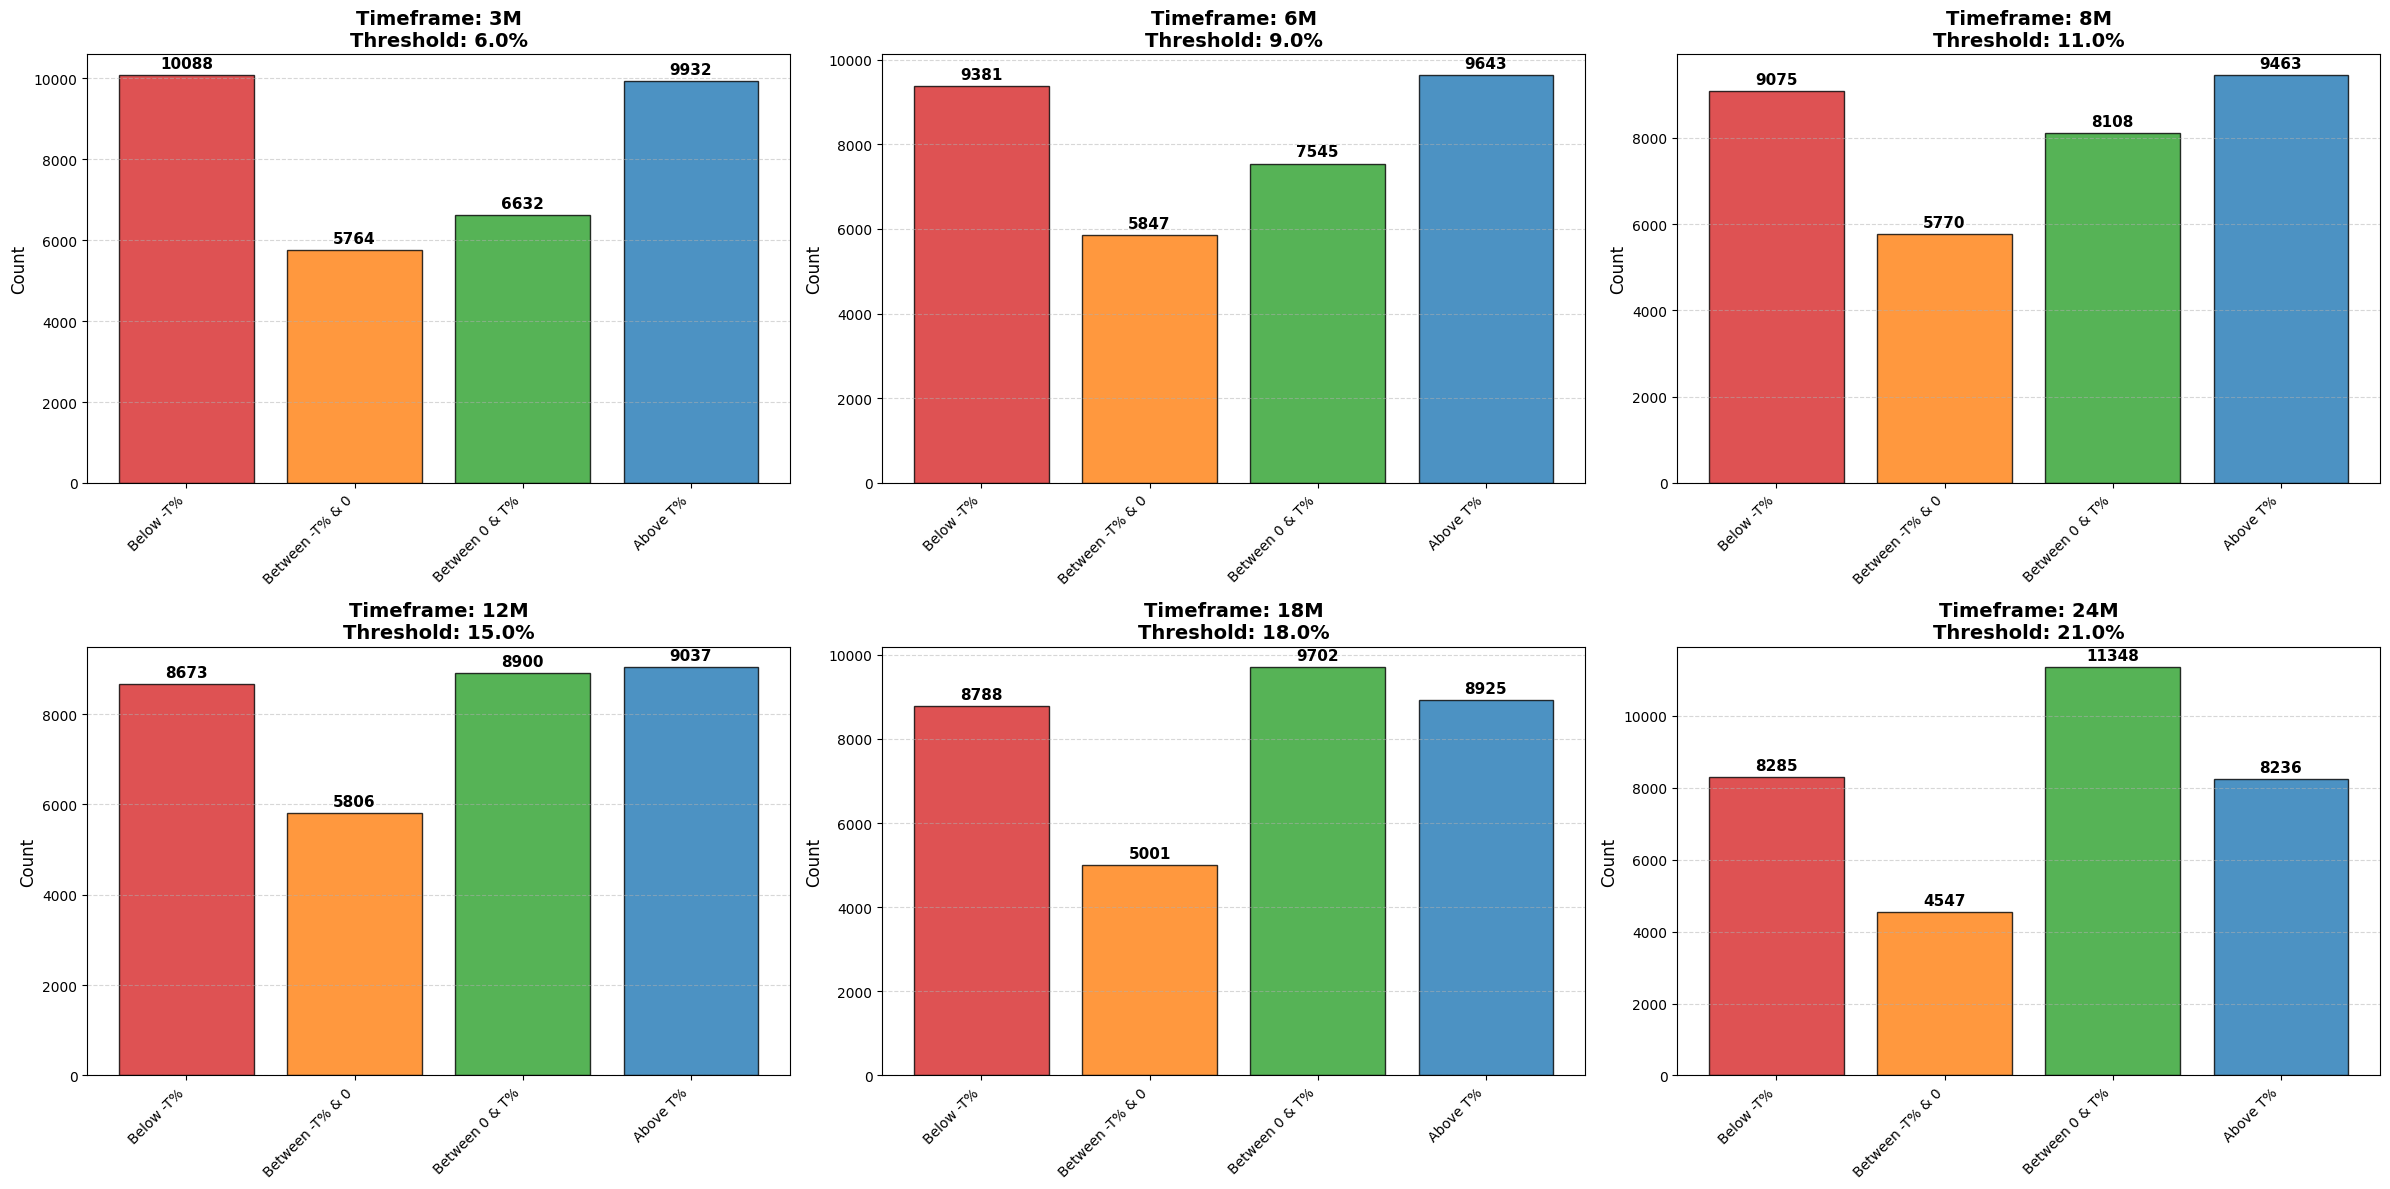

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
# Replace 'your_file.csv' with the actual path to your file
file_path = 'data/raw/ml_dataset_with_multiclass_labels.csv'
df = pd.read_csv(file_path)

# Define Timeframes and Thresholds
# Thresholds are converted to decimals (e.g., 4% -> 0.04)
tf_configs = {
    '3M': 0.06,
    '6M': 0.09,
    '8M': 0.11,
    '12M': 0.15,
    '18M': 0.18,
    '24M': 0.21
}

# Define categories/buckets
categories = ['Below -T%', 'Between -T% & 0', 'Between 0 & T%', 'Above T%']
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4'] # Red, Orange, Green, Blue

# Setup the figure
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten()

print("Calculating counts and generating plots...")

for i, (tf, thresh) in enumerate(tf_configs.items()):
    col_name = f'performance_{tf}'
    ax = axes[i]
    
    if col_name in df.columns:
        # Drop NaNs to ensure accurate counting
        data = df[col_name].dropna()
        
        # Calculate counts for each bucket
        # 1. Below -Threshold
        count_below = (data < -thresh).sum()
        
        # 2. Between -Threshold and 0 (inclusive of -T, exclusive of 0)
        count_neg_mid = ((data >= -thresh) & (data < 0)).sum()
        
        # 3. Between 0 and Threshold (inclusive of 0 and T)
        count_pos_mid = ((data >= 0) & (data <= thresh)).sum()
        
        # 4. Above Threshold
        count_above = (data > thresh).sum()
        
        counts = [count_below, count_neg_mid, count_pos_mid, count_above]
        
        # Plot Bar Chart
        bars = ax.bar(categories, counts, color=colors, edgecolor='black', alpha=0.8)
        
        # Formatting
        ax.set_title(f'Timeframe: {tf}\nThreshold: {thresh:.1%}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Count', fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Rotate x-labels
        ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
        
        # Add data labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + (max(counts)*0.01),
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
            
    else:
        # Handle missing columns
        ax.text(0.5, 0.5, f'Column {col_name}\nNot Found', 
                ha='center', va='center', fontsize=14, color='red')
        ax.set_title(f'Timeframe: {tf}', fontsize=14)
        ax.axis('off')

plt.tight_layout()
plt.show()